In [1]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Serif"

import requests
import wget
import shutil
import gzip
import json
import ipaddress
from sklearn.linear_model import LinearRegression
import numpy as np

import geoplot.crs as gcrs
import geoplot
import os
from datetime import datetime
import socket 
import sys
import netaddr
import pycountry_convert as pc
import seaborn.apionly as sns
import plotly.graph_objects as go
import plotly.express as px
import holoviews as hv
from holoviews import opts, dim


/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [4]:


import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import json
from dask.distributed import Client, LocalCluster


In [5]:
import pyipmeta as ipm
meta = ipm.IpMeta(providers=["pfx2as -f " + 'pfx_to_as/routeviews-rv2-20220920-1200.txt'])


In [36]:
def asn_dask(x):    
    
    #print(x)
    asninfo = meta.lookup(x)
    #print(asninfo)
    if len(asninfo) == 1:
        return ','.join([str(asn) for asn in asninfo[0]['asns']])
    elif len(asninfo) == 0:
        return ''
    else:
        return ','.join([asninfo[i]['asns'] for i in range(len(asninfo))])
    

## Assigned AS numbers from NRO delegation file

In [1353]:
nro_df = pd.read_csv('data/nro-delegated-stats', sep='|')

/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [96]:
COLORS = ['#0f4d5c','#846aa5', '#ff837a']

# Block Availability Info  
- Trinocular sets the threshold for accurate outage detection when the block availability is at least 0.3  
- If we consider one survey and /24 to be block, the block availability is (number of responding hosts) / (256)  
- We want to find blocks with availability of at least 0.3  
- Combining the datasets gives us a 10% increase in the number of available blocks  


In [428]:
def get_blk_avail_cumsum(ba_df, colname='aeb_perc', div=1e6):
    
    ba_cdf = ba_df.groupby(colname)['/24'].count().reset_index()

    ba_cdf['cumsum'] = ba_cdf['/24'].cumsum() 
    ba_cdf['cumsum_greater'] = (ba_cdf['cumsum'].max() - ba_cdf['cumsum'])/div
    #ba_cdf.loc[::-1, '/24'].cumsum()[::-1]
    ba_cdf['frac'] = ba_cdf['cumsum']/ba_cdf['cumsum'].max()
    ba_cdf['frac_greater'] = 1 - ba_cdf['frac']
    return ba_cdf
    #ba_cdf.plot(x='availability', y='frac')

In [8]:
def plot_cdf(ant_df, combined_df,   ax=None,):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax = ant_df.plot(x='aeb_perc', y='cumsum_greater', ax=ax, lw=3,style='--', color='#0d4f5c', grid=True)
    #ax = censys_df.plot(x='availability', y='frac', ax=ax)
    combined_df.plot(x='aeb_perc', y='cumsum_greater', ax=ax, lw=3, color='#846aa5', grid=True)
    #ax.legend(['ANT', 'Combined'], fontsize=20)
    
    
    ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
    plt.axvline(x=30, c='r', ls='--')
    plt.text(0.47, 0.27, 'A(E(b))=30%', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize=15)
    return ax

In [417]:
def plot_cdf_one(df, style, color, colname=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax = df.plot(x=colname, y='cumsum_greater', ax=ax, lw=3, style=style, c=color, grid=True)
    
    plt.axvline(x=30, c='r', ls='--', label='_nolegend_')
    #ax.set_ylabel('# of /24 blocks unique\n to Censys', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
    
    
    #plt.savefig('figs_analysis_2/censys_block_avail_new.pdf', bbox_inches='tight')
    return ax

In [10]:

def ip2int(x):
    try:
        return netaddr.IPAddress(x).value
    except:
        return None

def int2ip24(x):
    ip =  str(netaddr.IPAddress(int(x)))
    return ip2int('.'.join(ip.split('.')[0:3]) + '.0')

def int2ip(x):
    try:
        return str(netaddr.IPAddress(int(x)))
    except:
        return None

def get_24_from_int(df):
    return df['ipint'].apply(lambda x: int2ip24(x))

## Load block availability

In [641]:
cluster = LocalCluster(n_workers=16, threads_per_worker=1, dashboard_address=':37938')  # Launches a scheduler and workers locally
client = Client(cluster) 
cluster.dashboard_link

/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning:

Port 37938 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37915 instead

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


'http://127.0.0.1:37915/status'

In [640]:
client.shutdown()

In [12]:
def get_files_no_pfx(dirname):
    
    files = [os.path.join(dirname, f) for f in os.listdir(dirname)]
    return files
def get_dirs(dirname):
    dirs = [os.path.join(dirname, f) for f in os.listdir(dirname) if os.path.isdir(os.path.join(dirname, f))]
    return dirs
def get_files(dirname, pfx):
    files = [os.path.join(dirname, f) for f in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, f)) and pfx in f]
    return files

### Load ANT (merged index)

In [13]:
dirname = '/data1/manasvini/ant_intermediate_new/aeb'

files = list(set(get_files_no_pfx(dirname)))

ant_aeb_ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='200MB')


### Load ANT + Censys

In [14]:
dirname = '/data1/manasvini/ant_censys_merged_new/aeb'

files = list(set(get_files_no_pfx(dirname)))

antcensys_aeb_ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='200MB')


In [420]:
antcensys_aeb_24_df = antcensys_aeb_ddf.groupby('/24').count().compute().reset_index()

In [ ]:
ant_aeb_24_df = antcensys_aeb_ddf.groupby('/24').count().compute().reset_index()

In [ ]:
#### ANT available blcoks

## Load ANT + Censys (best)

In [15]:
dirname = '/data1/manasvini/censys/proto/aeb'

files = list(set(get_files_no_pfx(dirname)))

antcensys_best_aeb_ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='200MB')


In [11]:
proto_ct_all_ddf = dd.read_parquet('/data1/manasvini/censys/proto/best_proto', block_size='10MB')

In [12]:
proto_ct_all_ddf['/24'] = proto_ct_all_ddf.map_partitions(get_24_from_int)

In [17]:
proto_ct_24_df = proto_ct_all_ddf[proto_ct_all_ddf['best_proto_val']>0].groupby('/24')['ipint'].count().compute()

In [16]:
ant_aeb24_df = ant_aeb_ddf.groupby('/24')['aeb'].mean().compute()
ant_aeb24_df = ant_aeb24_df.reset_index()
ant_aeb24_df['aeb_perc'] = (ant_aeb24_df['aeb'] * 100).astype(int)

In [1377]:
ant_host_count_df = ant_aeb_ddf.groupby('/24')['aeb'].mean().compute()

In [17]:
antcensys_aeb24_df = antcensys_aeb_ddf.groupby('/24')['aeb'].mean().compute()
antcensys_aeb24_df = antcensys_aeb24_df.reset_index()
antcensys_aeb24_df['aeb_perc'] = (antcensys_aeb24_df['aeb']*100).astype(int)

In [18]:
antcensys_best_aeb24_df = antcensys_best_aeb_ddf.groupby('/24')[['aeb_ant', 'aeb_combined']].mean().compute().reset_index()
antcensys_best_aeb24_df['aeb_ant_perc'] = (antcensys_best_aeb24_df['aeb_ant']*100).astype(int)
antcensys_best_aeb24_df['aeb_combined_perc'] = (antcensys_best_aeb24_df['aeb_combined']*100).astype(int)


#### Reliable ANT blocks

In [374]:
ant_reliable_24s = antcensys_best_aeb24_df[(antcensys_best_aeb24_df['aeb_ant_perc']>=30)&(antcensys_best_aeb24_df['/24'].isin(ant_24s_df['/24_int'].tolist()))]['/24'].tolist()


#### Unreliable ANT blocks

In [366]:
ant_unreliable = antcensys_best_aeb24_df[(antcensys_best_aeb24_df['aeb_ant_perc']<30)&(antcensys_best_aeb24_df['/24'].isin(ant_24s_df['/24_int'].tolist()))]['/24'].tolist()

In [362]:
ant_unavailable = antcensys_best_aeb24_df[~antcensys_best_aeb24_df['/24'].isin(ant_24s_df['/24_int'].tolist())]['/24']

In [401]:
ant_cdf = get_blk_avail_cumsum(ant_aeb24_df)
antcensys_cdf = get_blk_avail_cumsum(antcensys_aeb24_df)
ant_best_cdf = get_blk_avail_cumsum(antcensys_best_aeb24_df, 'aeb_ant_perc')
ant_best_cdf = ant_best_cdf[ant_best_cdf['aeb_ant_perc']<=100]
antcensys_best_cdf = get_blk_avail_cumsum(antcensys_best_aeb24_df, 'aeb_combined_perc')


[-1.  0.  1.  2.  3.  4.  5.  6.  7.] [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


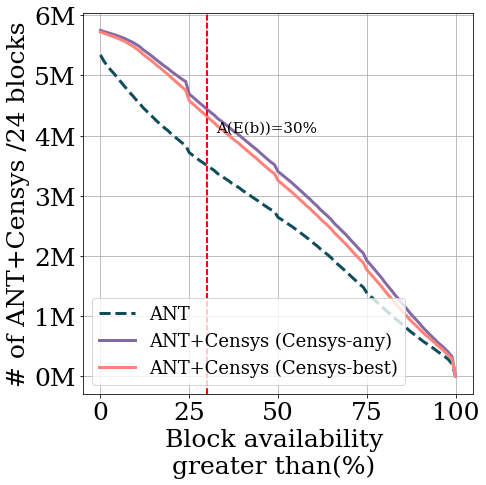

In [435]:
fig, ax = plt.subplots(figsize=(7,7))
#ax = plot_cdf_one(ant_cdf, '--', COLORS[0], 'aeb_perc', ax)
ax = plot_cdf_one(ant_best_cdf,'--', COLORS[0],  'aeb_ant_perc', ax)
ax = plot_cdf_one(antcensys_cdf,'-', COLORS[1], 'aeb_perc', ax)
ax = plot_cdf_one(antcensys_best_cdf,'-', COLORS[2],  'aeb_combined_perc', ax)
ax.legend(['ANT', 'ANT+Censys (Censys-any)', 'ANT+Censys (Censys-best)'], fontsize=18)
labels, locations = plt.yticks()
print(labels, locations)
#plt.yticks(labels, ['-2', '0', '2M', '4M', '6M', '8M'])
ax.yaxis.set_major_formatter('{x:1.0f}M')
ax.set_xlabel('Block availability \ngreater than(%) ', fontsize=25)
ax.set_ylabel('# of ANT+Censys /24 blocks', fontsize=25)
plt.text(0.47, 0.7, 'A(E(b))=30%', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize=15)
plt.savefig('figs_pam/blk_avail_combined_best_any.pdf', bbox_inches='tight')

## Remove ANT blocks and plot availability

In [19]:
dirname = '/data1/manasvini/internet_address_history_it101w-20221101/last10withipint/everalive'

files = list(set(get_files_no_pfx(dirname)))

ant_only_df = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='20MB')

In [20]:
#ant_only_df['/24']  =  ant_only_df.map_partitions(get_24_from_int)
ant_24s_df = ant_only_df.groupby('/24')['ipint'].count().compute().reset_index()

In [445]:
ant_24s_df['/24_str'] = ant_24s_df['/24'].apply(lambda x: int2ip(x))

In [430]:
censys_24_df = antcensys_aeb24_df[~antcensys_aeb24_df['/24'].isin(ant_24s_df['/24_int'])]
censys_cdf = get_blk_avail_cumsum(censys_24_df, div=1000)

censys_best_24_df = antcensys_best_aeb24_df[~antcensys_best_aeb24_df['/24'].isin(ant_24s_df['/24_int'])]
censys_best_cdf = get_blk_avail_cumsum(censys_best_24_df, 'aeb_combined_perc', div=1000)


Text(0.47, 0.7, 'A(E(b))=30%')

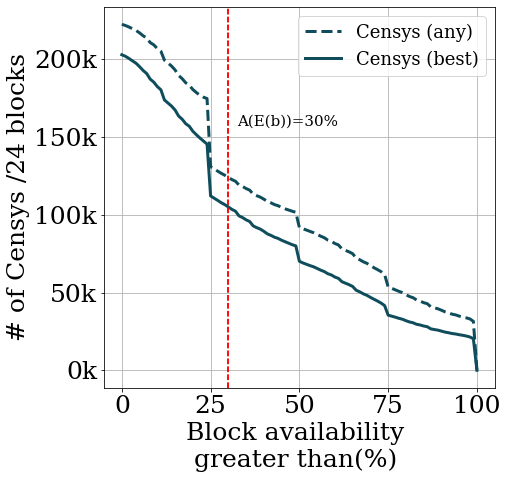

In [436]:
fig, ax = plt.subplots(figsize=(7,7))
ax = plot_cdf_one(censys_cdf, '--', COLORS[0], 'aeb_perc', ax)
ax = plot_cdf_one(censys_best_cdf, '-', COLORS[0], 'aeb_combined_perc', ax)
ax.legend([ 'Censys (any)', 'Censys (best)'], fontsize=18)
ax.set_xlabel('Block availability \ngreater than(%) ', fontsize=25)
ax.set_ylabel('# of Censys only /24 blocks', fontsize=25)
ax.yaxis.set_major_formatter('{x:1.0f}k')
ax.set_xlabel('Block availability \ngreater than(%) ', fontsize=25)
ax.set_ylabel('# of Censys /24 blocks', fontsize=25)
plt.text(0.47, 0.7, 'A(E(b))=30%', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize=15)
#plt.savefig('figs_pam/censys_blk_avail_combined_best_any.pdf', bbox_inches='tight')

## Look at ANT only

In [440]:
antcensys_24_df = antcensys_aeb24_df[antcensys_aeb24_df['/24'].isin(ant_24s_df['/24_int'])]
ant_only_24_df = ant_aeb24_df[ant_aeb24_df['/24'].isin(ant_24s_df['/24_int'])]

antcensys_best_24_df = antcensys_best_aeb24_df[antcensys_best_aeb24_df['/24'].isin(ant_24s_df['/24_int'])]
ant_only_24_best_df = antcensys_best_aeb24_df[antcensys_best_aeb24_df['/24'].isin(ant_24s_df['/24_int'])][['/24', 'aeb_ant_perc']]

In [486]:
ant_unreliable = ant_only_24_df[ant_only_24_df['aeb_perc']<30]

In [487]:
ant_unreliable_combined_reliable = antcensys_aeb24_df[(antcensys_aeb24_df['aeb_perc']>=30)&(ant_unreliable['/24'].isin(ant_only_24_df['/24'].tolist()))]

In [488]:
ant_unreliable_merged = ant_unreliable_combined_reliable.merge(ant_only_24_df, on='/24', how='inner')

In [441]:


ant_cdf = get_blk_avail_cumsum(ant_only_24_df)
antcensys_cdf = get_blk_avail_cumsum(antcensys_24_df)

ant_best_cdf = get_blk_avail_cumsum(ant_only_24_best_df, 'aeb_ant_perc')
antcensys_best_cdf = get_blk_avail_cumsum(antcensys_best_24_df, 'aeb_combined_perc')


#plot_cdf(ant_cdf, antcensys_cdf, 'figs_analysis_2/ant_block_avail_new.pdf')

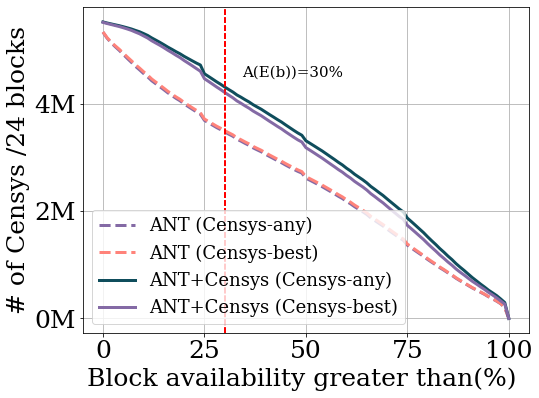

In [450]:
fig, ax = plt.subplots(figsize=(8,6))
ax = plot_cdf_one(ant_cdf, '--', COLORS[1], 'aeb_perc', ax)
ax = plot_cdf_one(ant_best_cdf,'--', COLORS[2],  'aeb_ant_perc', ax)
ax = plot_cdf_one(antcensys_cdf,'-', COLORS[0], 'aeb_perc', ax)
ax = plot_cdf_one(antcensys_best_cdf,'-', COLORS[1],  'aeb_combined_perc', ax)
ax.legend(['ANT (Censys-any)','ANT (Censys-best)', 'ANT+Censys (Censys-any)', 'ANT+Censys (Censys-best)'], fontsize=18)
ax.set_xlabel('Block availability greater than(%) ', fontsize=25)
ax.yaxis.set_major_formatter('{x:1.0f}M')
ax.set_ylabel('# of /24 blocks', fontsize=25)
ax.set_ylabel('# of Censys /24 blocks', fontsize=25)
plt.text(0.47, 0.8, 'A(E(b))=30%', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize=15)

plt.savefig('figs_pam/ant_blk_avail_combined_best_any.pdf', bbox_inches='tight')

## How much of a difference did Censys make per /24?  
We want to know if adding Censys data changed the availability by a large margin or not.  
- We first identify blocks with availability < 0.3 in ANT. Then we check the combined data for new availability 
- Consider the blocks with new availability > 0.3 
- We then plot a CDF of the change in availability.  
- 1.01 million blocks now are avaialble, with an average change of 39.5\% 


In [445]:
ant_aeb24_tmpdf = ant_aeb24_df.rename(columns={'aeb_perc':'ant_aeb_perc', 'aeb':'ant_aeb'})
merged_aeb_df = antcensys_aeb24_df.merge(ant_aeb24_tmpdf, on='/24', how='inner')

In [446]:
merged_best_aeb_df = antcensys_best_aeb24_df[antcensys_best_aeb24_df['/24'].isin(ant_24s_df['/24_int'])]

In [447]:
merged_best_aeb_df = merged_best_aeb_df.rename(columns={'aeb_combined_perc':'aeb_perc', 'aeb_ant_perc':'ant_aeb_perc'})

In [448]:
def plot_merge_diff(merged_aeb_df, color, style, ax):
    merged_aeb_df['diff'] = merged_aeb_df['aeb_perc'] - merged_aeb_df['ant_aeb_perc']
    merged_aeb_df = merged_aeb_df[(merged_aeb_df['aeb_perc']>=30)&(merged_aeb_df['ant_aeb_perc']<=30)]
    merged_aeb_cdf_df = merged_aeb_df.groupby('diff')['/24'].count().reset_index()
    merged_aeb_cdf_df['cumsum'] = merged_aeb_cdf_df['/24'].cumsum()
    merged_aeb_cdf_df['frac'] = merged_aeb_cdf_df['cumsum'] / merged_aeb_cdf_df['cumsum'].max()
    print(merged_aeb_cdf_df[merged_aeb_cdf_df['diff']==50], merged_aeb_df['diff'].mean(), len( merged_aeb_df[merged_aeb_df['diff']>0]))

    ax = merged_aeb_cdf_df.set_index('diff')['frac'].plot(ax=ax, lw=2,  c=color, style=style, grid=True)
    return ax


    diff    /24  cumsum      frac
50    50  27978  758391  0.747552 39.794807294233614 1007390
    diff    /24  cumsum      frac
50    50  10073  629922  0.824813 33.95921646163818 754497


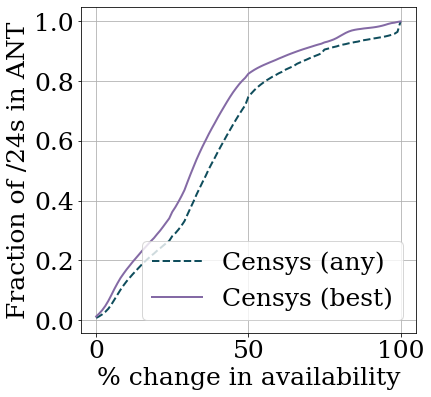

In [453]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = plot_merge_diff(merged_aeb_df,COLORS[0], '--', ax)
ax = plot_merge_diff(merged_best_aeb_df, COLORS[1], '-', ax)
ax.set_xlabel('% change in availability', fontsize=25)
ax.set_ylabel('Fraction of /24s in ANT', fontsize=25)
ax.legend(['Censys (any)', 'Censys (best)'], fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
plt.savefig('figs_pam/avail_improvement_new.pdf', bbox_inches='tight')


## /24 blocks above  0.3 availability grouped by AS 

In [28]:
ant_24s_df['/24_int'] = ant_24s_df['/24'].apply(lambda x: ip2int(x))

In [30]:
ant_only_aeb_24_df =  ant_aeb24_df[ant_aeb24_df['/24'].isin(ant_24s_df['/24_int'].tolist())]

In [31]:
ant_only_aeb_24_df['/24_str'] = ant_only_aeb_24_df['/24'].apply(lambda x:int2ip(x))

/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [121]:
merged_aeb_df = ant_only_aeb_24_df.merge(antcensys_aeb24_df[['/24', 'aeb_perc']], on='/24', how='inner')

In [144]:
merged_aeb_df['diff'] = (merged_aeb_df['aeb_combined_perc'] - merged_aeb_df['aeb_perc'])

In [142]:
merged_aeb_df = ant_only_aeb_24_df.merge(antcensys_best_aeb24_df[['/24', 'aeb_combined_perc']], on='/24', how='inner')

In [33]:
antcensys_24s = antcensys_aeb24_df['/24'].to_frame()
antcensys_24s['/24_str'] = antcensys_24s['/24'].apply(lambda x: int2ip(x))

In [37]:
antcensys_24s['asn'] = antcensys_24s['/24_str'].apply(lambda x:asn_dask(x))

In [41]:
ant_aeb24_asn_df = ant_aeb24_df.merge(antcensys_24s[['/24', 'asn']], on='/24', how='inner')
antcensys_aeb24_asn_df = antcensys_aeb24_df.merge(antcensys_24s[['/24', 'asn']], on='/24', how='inner')

In [42]:
antcensys_best_aeb24_asn_df = antcensys_best_aeb24_df.merge(antcensys_24s[['/24', 'asn']], on='/24', how='inner')

In [91]:
ant_only_asn_df = ant_only_aeb_24_df.merge(antcensys_24s[['/24', 'asn']], on='/24', how='inner')
ant_only_alive_asn_df = ant_only_asn_df[ant_only_asn_df['aeb_perc']>=30].groupby('asn')['/24'].count().reset_index()
ant_only_aeb24_alive_asn_df = ant_only_alive_asn_df[ant_only_alive_asn_df['asn']!='']

In [44]:
ant_only_asn_df.rename(columns={'asn_x':'asn'}, inplace=True)
ant_only_aeb24_all_df = ant_only_asn_df.groupby('asn')['/24'].count().reset_index()
ant_only_aeb24_all_df = ant_only_aeb24_all_df[ant_only_aeb24_all_df['asn']!='']
ant_only_aeb24_all_df.rename(columns={'/24':'all_/24s'}, inplace=True)

In [45]:
ant_best_alive_asn_df = antcensys_best_aeb24_asn_df[(antcensys_best_aeb24_asn_df['/24'].isin(ant_24s_df['/24_int'].tolist())) &(antcensys_best_aeb24_asn_df['aeb_ant_perc']>=30)]\
                        .groupby('asn')['/24'].count().reset_index()
ant_best_alive_asn_df = ant_best_alive_asn_df[ant_best_alive_asn_df['asn']!='']

In [46]:
ant_best_all_asn_df = antcensys_best_aeb24_asn_df[(antcensys_best_aeb24_asn_df['/24'].isin(ant_24s_df['/24_int'].tolist()))]\
                        .groupby('asn')['/24'].count().reset_index()
ant_best_all_asn_df = ant_best_all_asn_df[ant_best_all_asn_df['asn']!='']
ant_best_all_asn_df.rename(columns={'/24':'all_/24s'}, inplace=True)

In [47]:
ant_aeb24_alive_asn_df = ant_aeb24_asn_df[ant_aeb24_asn_df['aeb_perc']>=30].groupby('asn')['/24'].count().reset_index()

antcensys_aeb24_alive_asn_df = antcensys_aeb24_asn_df[antcensys_aeb24_asn_df['aeb_perc']>=30].groupby('asn')['/24'].count().reset_index()


In [48]:
ant_best_aeb24_alive_asn_df = antcensys_best_aeb24_asn_df[antcensys_best_aeb24_asn_df['aeb_ant_perc']>=30].groupby('asn')['/24'].count().reset_index()
ant_best_aeb24_all_asn_df = antcensys_best_aeb24_asn_df.groupby('asn')['/24'].count().reset_index()

antcensys_best_aeb24_alive_asn_df = antcensys_best_aeb24_asn_df[antcensys_best_aeb24_asn_df['aeb_combined_perc']>=30].groupby('asn')['/24'].count().reset_index()
antcensys_best_aeb24_all_asn_df = antcensys_best_aeb24_asn_df.groupby('asn')['/24'].count().reset_index()

## All /24 blocks grouped by AS

In [49]:
antcensys_aeb24_alive_asn_df = antcensys_aeb24_alive_asn_df[antcensys_aeb24_alive_asn_df['asn']!='']
antcensys_aeb24_all_df = antcensys_aeb24_asn_df.groupby('asn')['/24'].count().reset_index()
antcensys_aeb24_all_df = antcensys_aeb24_all_df[antcensys_aeb24_all_df['asn']!='']
antcensys_aeb24_all_df.rename(columns={'/24':'all_/24s'}, inplace=True)

ant_aeb24_alive_asn_df = ant_aeb24_alive_asn_df[ant_aeb24_alive_asn_df['asn']!='']
ant_aeb24_all_df = ant_aeb24_asn_df.groupby('asn')['/24'].count().reset_index()
ant_aeb24_all_df = ant_aeb24_all_df[ant_aeb24_all_df['asn']!='']
ant_aeb24_all_df.rename(columns={'/24':'all_/24s'}, inplace=True)

In [50]:
antcensys_best_aeb24_alive_asn_df = antcensys_best_aeb24_alive_asn_df[antcensys_best_aeb24_alive_asn_df['asn']!='']
antcensys_best_aeb24_all_asn_df = antcensys_best_aeb24_all_asn_df[antcensys_best_aeb24_all_asn_df['asn']!='']
antcensys_best_aeb24_all_asn_df.rename(columns={'/24':'all_/24s'}, inplace=True)

antcensys_best_aeb24_alive_asn_df = antcensys_best_aeb24_alive_asn_df[antcensys_best_aeb24_alive_asn_df['asn']!='']
ant_best_aeb24_all_asn_df = ant_best_aeb24_all_asn_df[ant_best_aeb24_all_asn_df['asn']!='']
ant_best_aeb24_all_asn_df.rename(columns={'/24':'all_/24s'}, inplace=True)

## Get fraction of blocks per AS with > 0.3 availability

In [51]:
antcensys_asn_df = antcensys_aeb24_all_df.merge(antcensys_aeb24_alive_asn_df, on='asn', how='left').fillna(0)
ant_asn_df = ant_aeb24_all_df.merge(ant_aeb24_alive_asn_df, on='asn', how='left').fillna(0)
ant_asn_df['frac_alive_24'] =  (100 * ant_asn_df['/24'] / ant_asn_df['all_/24s']).astype(int)
['frac_alive_24'] =  (100 * antcensys_asn_df['/24'] / antcensys_asn_df['all_/24s']).astype(int)

In [52]:
antcensys_best_asn_df = antcensys_best_aeb24_all_asn_df.merge(antcensys_best_aeb24_alive_asn_df, on='asn', how='left').fillna(0)
ant_best_asn_df = ant_best_aeb24_all_asn_df.merge(ant_best_aeb24_alive_asn_df, on='asn', how='left').fillna(0)
ant_best_asn_df['frac_alive_24'] =  (100 * ant_best_asn_df['/24'] / ant_best_asn_df['all_/24s']).astype(int)
antcensys_best_asn_df['frac_alive_24'] =  (100 * antcensys_best_asn_df['/24'] / antcensys_best_asn_df['all_/24s']).astype(int)

In [53]:
merged_asn_alive_df = antcensys_asn_df.merge(ant_asn_df, on='asn', how='inner')
merged_asn_alive_df['diff'] = 100*(merged_asn_alive_df['/24_x'] - merged_asn_alive_df['/24_y'])/ merged_asn_alive_df['/24_y']
merged_asn_alive_df[merged_asn_alive_df['diff']>0]


,asn,all_/24s_x,/24_x,frac_alive_24_x,all_/24s_y,/24_y,frac_alive_24_y,diff
0,1,14,10.0,71,14,8.0,57,25.000000
1,100,2,2.0,100,2,1.0,50,100.000000
2,10000,247,184.0,74,247,146.0,59,26.027397
3,10001,123,110.0,89,123,108.0,87,1.851852
4,10002,90,81.0,90,90,80.0,88,1.250000
...,...,...,...,...,...,...,...,...
73962,9991,145,145.0,100,145,3.0,2,4733.333333
73963,9993,62,58.0,93,62,27.0,43,114.814815
73964,9997,59,47.0,79,59,42.0,71,11.904762
73965,9998,19,18.0,94,19,16.0,84,12.500000


In [456]:
merged_asn_best_alive_df = antcensys_best_asn_df.merge(ant_asn_df, on='asn', how='inner')
merged_asn_best_alive_df['diff'] = 100*(merged_asn_best_alive_df['/24_x'] - merged_asn_best_alive_df['/24_y'])/ merged_asn_alive_df['/24_y']
merged_asn_best_alive_df[merged_asn_best_alive_df['diff']>0]


,asn,all_/24s_x,/24_x,frac_alive_24_x,all_/24s_y,/24_y,frac_alive_24_y,diff
0,1,14,9.0,64,14,8.0,57,12.500000
1,100,2,2.0,100,2,1.0,50,100.000000
2,10000,246,182.0,73,247,146.0,59,24.657534
3,10001,123,110.0,89,123,108.0,87,1.851852
4,10002,90,81.0,90,90,80.0,88,1.250000
...,...,...,...,...,...,...,...,...
73946,9991,145,145.0,100,145,3.0,2,7100.000000
73947,9993,62,57.0,91,62,27.0,43,inf
73948,9997,59,47.0,79,59,42.0,71,1.466276
73949,9998,19,18.0,94,19,16.0,84,200.000000


In [117]:
merged_asn_alive_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_asn_alive_df['diff'].dropna().mean()

43.73531687368241

In [67]:
ant_dead_as = ant_asn_df[(ant_asn_df['frac_alive_24']==0)&(ant_asn_df['asn']!='')]['asn'].tolist()
antcensys_best_asn_df[(antcensys_best_asn_df['asn'].isin(ant_dead_as))&(antcensys_best_asn_df['frac_alive_24']>0)]

,asn,all_/24s,/24,frac_alive_24
32,10039,2,1.0,50
35,10043,2,2.0,100
36,10044,8,7.0,87
40,10050,1,1.0,100
41,10051,3,3.0,100
...,...,...,...,...
73922,9966,1,1.0,100
73923,9967,4,4.0,100
73925,9969,2,1.0,50
73931,9975,2,2.0,100


In [118]:
ant_only_asn_df = ant_only_aeb24_all_df.merge(ant_only_aeb24_alive_asn_df, on='asn', how='left').fillna(0)
ant_only_asn_df['frac_alive_24'] =  (100 * ant_only_asn_df['/24'] / ant_only_asn_df['all_/24s']).astype(int)


## CDF of fraction of /24 block  > 0.3 availability

In [132]:
def get_cumsum(df):
    cdf = df.groupby('frac_alive_24')['asn'].count().reset_index()
    cdf['cumsum'] = cdf['asn'].cumsum()
    cdf['cumfrac'] = cdf['cumsum'] / cdf['cumsum'].max()
    cdf['cumfrac'] = 1 -cdf['cumfrac']
    return cdf

In [169]:
ant_asn_cdf = get_cumsum(ant_asn_df)
antcensys_asn_cdf = get_cumsum(antcensys_asn_df)

ant_best_asn_cdf = get_cumsum(ant_best_asn_df)
antcensys_best_asn_cdf = get_cumsum(antcensys_best_asn_df)


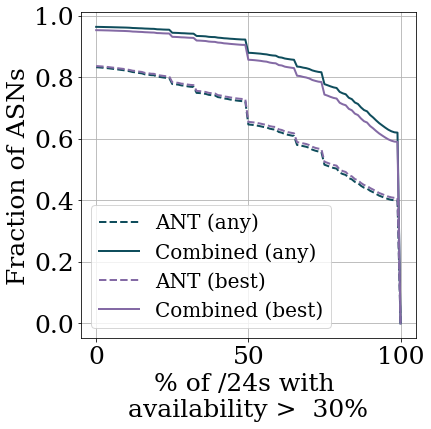

In [170]:
fig, ax = plt.subplots(figsize=(6,6))
ax = ant_asn_cdf.set_index('frac_alive_24')['cumfrac'].plot(ax=ax, lw=2, style='--', c=COLORS[0], grid=True)
ax = antcensys_asn_cdf.set_index('frac_alive_24')['cumfrac'].plot(ax=ax, lw=2, c=COLORS[0], grid=True)

ax = ant_best_asn_cdf.set_index('frac_alive_24')['cumfrac'].plot(ax=ax, lw=2, style='--', c=COLORS[1], grid=True)
ax = antcensys_best_asn_cdf.set_index('frac_alive_24')['cumfrac'].plot(ax=ax, lw=2, c=COLORS[1], grid=True)

ax.legend(['ANT (any)', 'Combined (any)', 'ANT (best)', 'Combined (best)'], fontsize=20)
ax.set_xlabel('% of /24s with \navailability >  30%', fontsize=25)
ax.set_ylabel('Fraction of ASNs', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
plt.savefig('figs_pam/as_24_avail_new.pdf', bbox_inches='tight')

## Fraction of /24 blocks only found in Censys with availability > 0.3 grouped by AS

In [72]:
censys_24_asn_df = censys_24_df.merge(antcensys_24s[['/24', 'asn']], on='/24', how='inner')
censys_24_asn_df = censys_24_asn_df[censys_24_asn_df['asn']!='']

In [73]:
censys_best_24_asn_df = censys_best_24_df.merge(antcensys_24s[['/24', 'asn']], on='/24', how='inner')
censys_best_24_asn_df = censys_best_24_asn_df[censys_best_24_asn_df['asn']!='']

In [74]:
censys_24_alive_asn_df = censys_24_asn_df[censys_24_asn_df['aeb_perc']>=30].groupby('asn')['/24'].count().reset_index()
censys_asn_all_df = censys_24_asn_df.groupby('asn')['/24'].count().reset_index()
censys_asn_all_df.rename(columns={'/24':'all_/24s'}, inplace=True)

In [75]:
censys_best_24_alive_asn_df = censys_best_24_asn_df[censys_best_24_asn_df['aeb_combined_perc']>=30].groupby('asn')['/24'].count().reset_index()
censys_best_asn_all_df = censys_best_24_asn_df.groupby('asn')['/24'].count().reset_index()
censys_best_asn_all_df.rename(columns={'/24':'all_/24s'}, inplace=True)

In [1467]:
asn_unique_df = censys_asn_df[(~censys_asn_df['asn'].isin(ant_only_asn_df['asn'].tolist()))&(censys_asn_df['/24']>0)][['asn']]

In [80]:
censys_asn_df = censys_asn_all_df.merge(censys_24_alive_asn_df, on='asn', how='left').fillna(0)

censys_asn_df['frac_alive_24'] =  (100 * censys_asn_df['/24'] / censys_asn_df['all_/24s'])

censys_asn_cdf = get_cumsum(censys_asn_df)


censys_best_asn_df = censys_best_asn_all_df.merge(censys_best_24_alive_asn_df, on='asn', how='left').fillna(0)

censys_best_asn_df['frac_alive_24'] =  (100 * censys_best_asn_df['/24'] / censys_best_asn_df['all_/24s'])

censys_best_asn_cdf = get_cumsum(censys_best_asn_df)
# .groupby('frac_alive_24')['asn'].count().reset_index()

# censys_asn_cdf['cumsum'] = censys_asn_cdf['asn'].cumsum()
# censys_asn_cdf['cumfrac'] = censys_asn_cdf['cumsum'] / censys_asn_cdf['cumsum'].max()
# censys_asn_cdf['cumfrac'] = 1 - censys_asn_cdf['cumfrac']


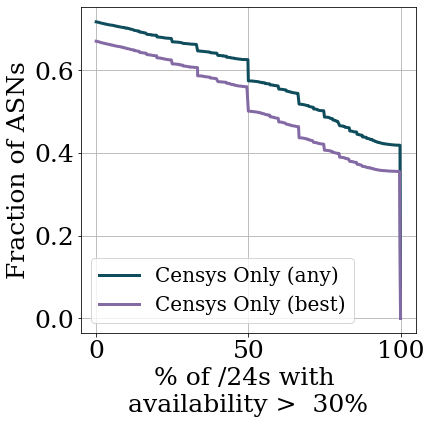

In [182]:
fig, ax = plt.subplots(figsize=(6,6))
ax = censys_asn_cdf.set_index('frac_alive_24')['cumfrac'].plot(ax=ax, lw=3, c=COLORS[0], grid=True)
ax = censys_best_asn_cdf.set_index('frac_alive_24')['cumfrac'].plot(ax=ax, lw=3, c=COLORS[1], grid=True)

#ax = antcensys_asn_cdf.set_index('frac_alive_24')['cumfrac'].plot(ax=ax)
ax.legend(['Censys Only (any)', 'Censys Only (best)'], fontsize=20)
ax.set_xlabel('% of /24s with \navailability >  30%', fontsize=25)
ax.set_ylabel('Fraction of ASNs', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
plt.savefig('figs_pam/as_24_avail_censys_new.pdf', bbox_inches='tight')

## Which ASes have improvement in availability, and how much?  
- Geolocate /24 blocks
- Group by ASN and compute mean improvement for the ASN 
- Group ASNs by country  


In [ ]:
maxmind_df = pd.read_csv('~/censys-ant/analysis/data/GeoLite2-City-Blocks-IPv4.csv')
geonames_df = pd.read_csv('~/censys-ant/analysis/data/GeoLite2-City-Locations-en.csv')

In [617]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [120]:
def combine_dfs(maxmind_df, subnet_df):
    maxmind_df['subnet_bits'] = maxmind_df['network'].str.split('/').str[-1].astype(int)
    maxmind_df = maxmind_df[maxmind_df['subnet_bits']<=32].reset_index()
    maxmind_df['/24'] = maxmind_df['network'].str.split('.').str[:-1].str.join('.')
    maxmind_df['/24'] = maxmind_df['/24'] + '.0'
    maxmind_subnet_df  = subnet_df.merge(maxmind_df, how='inner', on='/24')
    return maxmind_subnet_df

def filter_multi_country_24(maxmind_combined_df, geonames_df):
    merged_geo_df = geonames_df.merge(maxmind_combined_df, on='geoname_id', how='inner')
    geo_country_24_df = merged_geo_df.groupby(['/24','country_iso_code'])['geoname_id'].nunique().reset_index()
    
    count_24_df = geo_country_24_df.groupby(['/24'])['geoname_id'].sum().reset_index()
    count_24_df.rename(columns={'geoname_id':'count'}, inplace=True)
    merged_geo_country_24_df = geo_country_24_df.merge(count_24_df, on='/24', how='inner')
    merged_geo_country_24_df['frac'] = merged_geo_country_24_df['geoname_id'] / merged_geo_country_24_df['count']
    most_likely_country_df = merged_geo_country_24_df.groupby(['/24', 'country_iso_code'])['frac'].max().reset_index()
    max_prob_country_df = most_likely_country_df[most_likely_country_df['frac']> 0.5].reset_index()
    maxmind_filtered_df = merged_geo_df.merge(max_prob_country_df, on=['/24', 'country_iso_code'], how='inner')
    return maxmind_filtered_df

def populate_geoloc(df, maxmind_df, geonames_df):
    maxmind_combined_df = combine_dfs(maxmind_df, df)
    filtered_maxmind_combined_df = filter_multi_country_24(maxmind_combined_df, geonames_df)
    return filtered_maxmind_combined_df


In [615]:
def reconcile_names(as_country_df, world_df):
    countries_to_rename = {
     'United States':'United States of America',
     'Democratic Republic of the Congo': 'Dem. Rep. Congo',
     'Dominican Republic': 'Dominican Rep.',
     'East Timor':'Timor-Leste',
     'Ivory Coast': "Côte d'Ivoire", 
     'Central African Republic': 'Central African Rep.',
     'Republic of the Congo': 'Congo',
     'Equatorial Guinea': 'Eq. Guinea',
     'Swaziland':'eSwatini',
     'Palestinian Territory':'Palestine',
     'Solomon Islands':'Solomon Is.',
     'Cyprus':'N. Cyprus',
     'Somalia':'Somaliland',
     'Bosnia and Herzegovina':'Bosnia and Herz.',
      'South Sudan':'S. Sudan'}
    for c in countries_to_rename:
        as_country_df.loc[as_country_df['name']==c, 'name'] = countries_to_rename[c]

    return as_country_df

In [1481]:
ant_aeb24_asn_df['/24_str'] = ant_aeb24_asn_df['/24'].apply(lambda x: int2ip(x))
antcensys_aeb24_asn_df['/24_str'] = antcensys_aeb24_asn_df['/24'].apply(lambda x: int2ip(x))

In [ ]:
ant_aeb24_asn_df['/24_int'] = ant_aeb24_asn_df['/24']
ant_aeb24_asn_df['/24'] = ant_aeb24_asn_df['/24_str']

antcensys_aeb24_asn_df['/24_int'] = antcensys_aeb24_asn_df['/24']
antcensys_aeb24_asn_df['/24'] = antcensys_aeb24_asn_df['/24_str']

In [ ]:
maxmind_df['subnet_bits'] = maxmind_df['network'].str.split('/').str[-1].astype(int)

## Extract /24 blocks from MaxMind  
- Networks of varying sizes in MaxMind  
- First get all the prefixes  
- List all /24 within that prefix  
- Find the /24s which overlap with ANT and Censys /24s  
- Map back to the original prefix to geolocate the ANT or Censys /24  

In [588]:
def get_country_code(x):
    data = meta.lookup(x)
    if len(data) == 0:
        return ''
    data = data[0]
    if 'country_code' not in data:
        return ''
    return data['country_code']

In [593]:
maxmind_df = pd.read_csv('data/GeoLite2-City-Locations-en.csv')
country_code_to_name = maxmind_df[['country_iso_code', 'country_name']].drop_duplicates()
country_code_to_name.rename(columns={'country_iso_code':'country_code'}, inplace=True)

In [1487]:
ant_aeb24_df['/24_str'] = ant_aeb24_df['/24'].apply(lambda x: int2ip(x))
antcensys_aeb24_df['/24_str'] = antcensys_aeb24_df['/24'].apply(lambda x: int2ip(x))

#ant_aeb24_df['country_code'] = ant_aeb24_df['/24_str'].apply(lambda x: get_country_code(x))
#ant_aeb24_geo_df = ant_aeb24_df.merge(country_code_to_name, on='country_code', how='inner')

#antcensys_aeb24_df['country_code'] = antcensys_aeb24_df['/24_str'].apply(lambda x: get_country_code(x))
#antcensys_aeb24_geo_df = antcensys_aeb24_df.merge(country_code_to_name, on='country_code', how='inner')


## IpInfo: Load data

In [554]:
ipinfo_ddf = dd.read_parquet(get_files('/data1/manasvini/ipinfo', 'parquet'), blocksize='10MB')
ipinfo_cidr_ddf = dd.read_parquet(get_files('/data1/manasvini/ipinfo_expanded', 'parquet'), blocksize='10MB')


In [555]:
ipinfo_cidr_ddf = ipinfo_cidr_ddf.rename(columns={'/24_strs':'/24_str'})
#ipinfo_cidr_ddf['/24'] = ipinfo_cidr_ddf.map_partitions(ip2intdask, meta=('/24_str', 'str')).astype(int)


In [527]:
def ip2intdaskactual(df):
    return df['/24_actual'].apply(lambda x: ip2int(x))

def ip2intdask(df):
    return df['/24_str'].apply(lambda x: ip2int(x))

def get_24(df):
    return df['/24_str'].apply(lambda x: '.'.join(x.split('.')[:-1])+'.0')


In [549]:
def get_pfx(x):
    return x.split('/')[-1]

def get_pfx_dask(df):
    return df['cidr'].apply(lambda x: int(get_pfx(x)))



In [556]:
ipinfo_cidr_ddf['cidr_pfx'] = ipinfo_cidr_ddf.map_partitions(get_pfx_dask, meta=('cidr', 'str')).astype(int)

ipinfo_cidr_ddf['/24_actual'] = ipinfo_cidr_ddf.map_partitions(get_24, meta=('/24_str', 'str'))
ipinfo_cidr_ddf = ipinfo_cidr_ddf[ipinfo_cidr_ddf['/24_actual'].str.len()>0]
ipinfo_cidr_ddf['/24'] = ipinfo_cidr_ddf.map_partitions(ip2intdaskactual, meta=('/24_actual', str))
ipinfo_cidr_ddf = ipinfo_cidr_ddf[['cidr', '/24', 'cidr_pfx']]

In [558]:
ipinfo_cidr_ddf = ipinfo_cidr_ddf.dropna()
ipinfo_cidr_ddf['/24'] = ipinfo_cidr_ddf['/24'].astype(int)

In [559]:
ipinfo_24s = ipinfo_cidr_ddf.dropna()[(ipinfo_cidr_ddf['cidr_pfx']<=24)].groupby('/24')['cidr_pfx'].max().compute().reset_index()

In [561]:
ipinfo_24s_cidrpfx_df = ipinfo_24s.groupby('/24')['cidr_pfx'].max().reset_index()
#ipinfo_24s_cidr_df = ipinfo_24s_cidrpfx_df.merge(ipinfo_24s_filtered, on='/24', how='inner')

In [564]:
ipinfo_cidr_ddf.dtypes

cidr        object
/24          int64
cidr_pfx     int64
dtype: object

In [565]:
ipinfo_cidr_filtered_df = ipinfo_cidr_ddf[ipinfo_cidr_ddf['/24'].isin(ipinfo_24s_cidrpfx_df['/24'].tolist())].compute()

In [574]:
antcensys_best_aeb24_ddf.columns

Index(['/24', 'aeb_ant', 'aeb_combined', 'aeb_ant_perc', 'aeb_combined_perc'], dtype='object')

In [567]:
ipinfo_cidr_filtered_df['/24'] = ipinfo_cidr_filtered_df['/24'].astype(int)

In [569]:
ipinfo_cidr_filtered_df = ipinfo_cidr_filtered_df[ipinfo_cidr_filtered_df['/24'].isin(antcensys_aeb24_df['/24'])]

In [572]:
ipinfo_cidr_filtered_ddf = dd.from_pandas(ipinfo_cidr_filtered_df, npartitions=50)

In [573]:
antcensys_aeb24_ddf = dd.from_pandas(antcensys_aeb24_df, npartitions=50)
ant_aeb24_ddf = dd.from_pandas(ant_aeb24_df, npartitions=50)
antcensys_best_aeb24_ddf = dd.from_pandas(antcensys_best_aeb24_df, npartitions=50)

In [57]:
ant_cidr_ddf = ipinfo_cidr_filtered_ddf.merge(ant_aeb24_ddf[['/24', 'aeb_perc']], on='/24', how='inner')
#ant_cidr_ddf = ant_cidr_ddf.rename(columns={'country_name':'country_maxmind'})

In [58]:
antcensys_cidr_ddf = ipinfo_cidr_filtered_ddf.merge(antcensys_aeb24_ddf[['/24', 'aeb_perc']], on='/24', how='inner')
#antcensys_cidr_ddf = antcensys_cidr_ddf.rename(columns={'country_name':'country_maxmind'})

In [575]:
antcensys_best_cidr_ddf = ipinfo_cidr_filtered_ddf.merge(antcensys_best_aeb24_ddf[['/24', 'aeb_combined_perc', 'aeb_ant_perc']], on='/24', how='inner')
#antcensys_cidr_ddf = antcensys_cidr_ddf.rename(columns={'country_name':'country_maxmind'})

In [576]:
#antcensys_ipinfo_ddf = antcensys_cidr_ddf.merge(ipinfo_ddf, on='cidr', how='inner')
#ant_ipinfo_ddf = ant_cidr_ddf.merge(ipinfo_ddf, on='cidr', how='inner')
antcensys_best_ipinfo_ddf = antcensys_best_cidr_ddf.merge(ipinfo_ddf, on='cidr', how='inner')

In [580]:
country_codes = None
with open('data/country_codes.json') as fh:
    country_codes = json.load(fh)

In [581]:
data = []
for c in country_codes:
    data.append({'country':c, 'country_ipinfo': country_codes[c]})

In [579]:
def get_ipinfo_countrycode(x):
    if x in country_codes:
        return country_codes[x]
    return ''

In [577]:
#ant_ipinfo_ddf['country_ipinfo'] = ant_ipinfo_ddf.apply(lambda x: get_ipinfo_countrycode(x['country']), axis=1, meta=('country', str))
#antcensys_ipinfo_ddf['country_ipinfo'] = antcensys_ipinfo_ddf.apply(lambda x: get_ipinfo_countrycode(x['country']), axis=1, meta=('country', str))
antcensys_best_ipinfo_ddf['country_ipinfo'] = antcensys_best_ipinfo_ddf.apply(lambda x: get_ipinfo_countrycode(x['country']), axis=1, meta=('country', str))


In [65]:
antcensys_ipinfo_df = antcensys_ipinfo_ddf.compute()


In [66]:
ant_ipinfo_df = ant_ipinfo_ddf.compute()


In [582]:
antcensys_best_ipinfo_df = antcensys_best_ipinfo_ddf.compute()

In [639]:
antcensys_best_24_ct[antcensys_best_24_ct['country_ipinfo'].isin(['Ethiopia', 'Israel', 'French Polynesia', 'French Guiana', 'Suriname'])]

,country_ipinfo,/24_str
105,Israel,106672
210,Suriname,484
76,French Polynesia,482
75,French Guiana,440
69,Ethiopia,409


In [712]:
antcensys_best_ipinfo_df = antcensys_best_ipinfo_df.sort_values(by='cidr_pfx')
antcensys_best_ipinfo_df = antcensys_best_ipinfo_df.drop_duplicates(subset=['/24'], keep='last')

In [713]:
antcensys_best_ipinfo_df

,cidr,/24,cidr_pfx,aeb_combined_perc,aeb_ant_perc,start_ip,end_ip,join_key,city,region,country,latitude,longitude,postal_code,timezone,country_ipinfo,/24_str,country_code
964,3.73.0.0/16,55166976,16,36,9,3.73.0.0,3.73.255.255,3.73.0.0,Frankfurt am Main,Hesse,DE,50.11552,8.68417,60306,Europe/Berlin,Germany,3.73.200.0,
1324,95.56.0.0/16,1597540608,16,76,65,95.56.126.160,95.56.143.255,95.56.0.0,Almaty,Almaty,KZ,43.25000,76.91667,nan,Asia/Almaty,Kazakhstan,95.56.137.0,
1308,95.56.0.0/16,1597538304,16,79,69,95.56.126.160,95.56.143.255,95.56.0.0,Almaty,Almaty,KZ,43.25000,76.91667,nan,Asia/Almaty,Kazakhstan,95.56.128.0,
1270,171.116.0.0/16,2876562176,16,67,66,171.116.0.0,171.116.255.255,171.116.0.0,Taiyuan,Shanxi,CN,37.86944,112.56028,nan,Asia/Shanghai,China,171.116.219.0,
1269,171.116.0.0/16,2876530688,16,50,48,171.116.0.0,171.116.255.255,171.116.0.0,Taiyuan,Shanxi,CN,37.86944,112.56028,nan,Asia/Shanghai,China,171.116.96.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,129.208.25.123/32,2177898752,32,11,6,129.208.25.123,129.208.25.123,129.208.0.0,Jizan,Jazan Region,SA,16.88917,42.55111,nan,Asia/Riyadh,Saudi Arabia,129.208.25.0,
2876,189.87.142.192/32,3176631808,32,92,92,189.87.142.192,189.87.142.192,189.87.0.0,Rio de Janeiro,Rio de Janeiro,BR,-22.90642,-43.18223,20000-000,America/Sao_Paulo,Brazil,189.87.142.0,
5716,82.13.48.226/32,1376595968,32,71,71,82.13.48.226,82.13.48.226,82.13.0.0,Newmarket,England,GB,52.24467,0.40418,CB8,Europe/London,United Kingdom,82.13.48.0,
2903,176.184.67.164/32,2964865792,32,18,2,176.184.67.164,176.184.67.164,176.184.0.0,Allery,Hauts-de-France,FR,49.96398,1.89829,80270,Europe/Paris,France,176.184.67.0,


In [591]:
#antcensys_ipinfo_df['/24_str'] = antcensys_ipinfo_df['/24'].apply(lambda x: int2ip(x))
#ant_ipinfo_df['/24_str'] = ant_ipinfo_df['/24'].apply(lambda x: int2ip(x))
antcensys_best_ipinfo_df['/24_str'] = antcensys_best_ipinfo_df['/24'].apply(lambda x: int2ip(x))

In [ ]:
#antcensys_ipinfo_df['country_code'] = antcensys_ipinfo_df['/24_str'].apply(lambda x: get_country_code(x))
antcensys_best_ipinfo_df['country_code'] = antcensys_best_ipinfo_df['/24_str'].apply(lambda x: get_country_code(x))

#ant_ipinfo_df['country_code'] = ant_ipinfo_df['/24_str'].apply(lambda x: get_country_code(x))

In [597]:
#ant_aeb24_geo_df = ant_ipinfo_df.merge(country_code_to_name, on='country_code', how='inner')
#antcensys_aeb24_geo_df = antcensys_ipinfo_df.merge(country_code_to_name, on='country_code', how='inner')
antcensys_best_aeb24_geo_df = antcensys_best_ipinfo_df.merge(country_code_to_name, on='country_code', how='inner')

In [723]:
antcensys_24_ct = antcensys_ipinfo_df[antcensys_ipinfo_df['aeb_perc']>=30].groupby(['country_ipinfo', 'continent'])['/24_str'].count().reset_index().sort_values(by='/24_str', ascending=False)

In [714]:
antcensys_best_24_ct = antcensys_best_ipinfo_df[antcensys_best_ipinfo_df['aeb_combined_perc']>=30].groupby(['country_ipinfo'])['/24_str'].count().reset_index().sort_values(by='/24_str', ascending=False)

In [715]:
ant_best_24_ct = antcensys_best_ipinfo_df[antcensys_best_ipinfo_df['aeb_ant_perc']>=30].groupby(['country_ipinfo'])['/24_str'].count().reset_index().sort_values(by='/24_str', ascending=False)

In [428]:
ant_24_ct  = ant_ipinfo_df[ant_ipinfo_df['aeb_perc']>=30].groupby(['country_ipinfo'])['/24_str'].count().reset_index().sort_values(by='/24_str', ascending=False)

In [430]:
ant_24_ct = ant_24_ct.rename(columns={'country_ipinfo':'name'})

In [716]:
merged_ct_df = antcensys_best_24_ct.merge(ant_best_24_ct, on='country_ipinfo', how='inner')
merged_ct_df['diff'] = merged_ct_df['/24_str_x'] - merged_ct_df['/24_str_y']
merged_ct_df['diff_perc'] = 100*( merged_ct_df['/24_str_x'] - merged_ct_df['/24_str_y'])/ merged_ct_df['/24_str_x']

In [1496]:
antcensys_country_24_df = antcensys_ipinfo_df[antcensys_ipinfo_df['aeb_perc']>=30][['/24_str', 'country_ipinfo','country' ]].groupby(['country_ipinfo', 'country'])['/24_str'].count().reset_index()
ant_country_24_df = ant_ipinfo_df[ant_ipinfo_df['aeb_perc']>=30][['/24_str', 'country_ipinfo','country' ]].groupby(['country_ipinfo', 'country'])['/24_str'].count().reset_index()
antcensys_country_24_df.rename(columns={'country_ipinfo':'name', '/24_str':'all_/24'}, inplace=True)
ant_country_24_df.rename(columns={'country_ipinfo':'name', '/24_str':'ant_/24'}, inplace=True)   

In [1533]:
top_30 = comp_gdf.sort_values(by='diff_perc', ascending=False).head(30)[['name', 'diff_perc', 'continent']]
top_30.rename(columns={'name':'country_ipinfo'}, inplace=True)

In [1334]:
comp_gdf[comp_gdf['continent_y']=='Africa'].sort_values(by='diff_perc', ascending=False).head(5)[['name', 'diff_perc']]

,name,diff_perc
66,Ethiopia,93.175074
135,Mayotte,92.187500
143,Morocco,55.750954
173,Reunion,48.242812
189,Seychelles,46.774194


In [1335]:
comp_gdf[comp_gdf['continent_y']=='Asia'].sort_values(by='diff_perc', ascending=False).head(5)[['name', 'diff_perc']]

,name,diff_perc
234,Yemen,73.469388
162,Palestine,68.524971
101,Israel,56.130298
160,Pakistan,55.656206
217,Turkey,53.876416


In [1339]:
comp_gdf[comp_gdf['continent_y']=='Australia'].sort_values(by='diff_perc', ascending=False).head(5)[['name', 'diff_perc']]

,name,diff_perc
73,French Polynesia,83.817427
220,Tuvalu,66.666667
150,New Zealand,54.548429
13,Australia,43.743063
233,Wallis and Futuna,42.857143


In [1336]:
comp_gdf[comp_gdf['continent_y']=='South America'].sort_values(by='diff_perc', ascending=False).head(5)[['name', 'diff_perc']]

,name,diff_perc
203,Suriname,89.919355
72,French Guiana,74.336283
231,Venezuela,56.066461
10,Argentina,51.510028
45,Colombia,27.281905


In [1338]:
comp_gdf[comp_gdf['continent_y']=='Europe'].sort_values(by='diff_perc', ascending=False).head(5)[['name', 'diff_perc']]

,name,diff_perc
5,Andorra,80.327869
99,Ireland,76.258720
80,Greece,53.255791
68,Faroe Islands,49.305556
28,Bosnia and Herz.,40.539054


Empty DataFrame
Columns: [name, diff_perc, ant_aeb_perc, all_aeb_perc]
Index: []


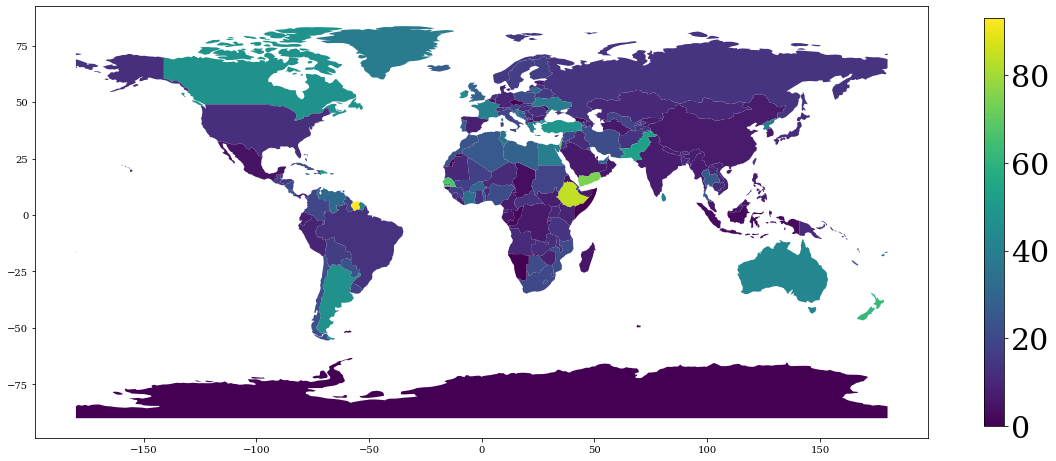

In [622]:
ant_country_24_df = antcensys_best_ipinfo_df[['aeb_ant_perc', 'country_ipinfo', ]].groupby('country_ipinfo')['aeb_ant_perc'].mean().reset_index()

antcensys_best_country_24_df = antcensys_best_ipinfo_df[['aeb_combined_perc', 'country_ipinfo', ]]\
                                            .groupby('country_ipinfo')['aeb_combined_perc'].mean().reset_index()
antcensys_best_country_24_df.rename(columns={'country_ipinfo':'name', 'aeb_combined_perc':'all_aeb_perc'}, inplace=True)
ant_country_24_df.rename(columns={'country_ipinfo':'name', 'aeb_ant_perc':'ant_aeb_perc'}, inplace=True)   
make_world_plot(ant_country_24_df, antcensys_best_country_24_df, 'ant_aeb_perc', 'all_aeb_perc', 'figs_pam/country_best_improvement_aeb_perc_ipinfo_new.pdf', '')

In [156]:
def get_continent_for_country(x):
    
    try:
        #country_code = pc.country_name_to_country_alpha2(x, cn_name_format="default")
        continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Australia',
        'AF': 'Africa',
        'EU': 'Europe',
        'AQ': 'Antarctica'
        }
        if country_code !='AQ':
            continent_name = pc.country_alpha2_to_continent_code(x)
        else:
            continent_name = 'AQ'
        if continent_name in continents:
            return continents[continent_name]

        return ''
    except:
        return ''


In [159]:
antcensys_country_24_df['continent'] = antcensys_country_24_df.apply(lambda x:get_continent_for_country(x['country']), axis=1)
ant_country_24_df['continent'] = ant_country_24_df.apply(lambda x:get_continent_for_country(x['country']), axis=1)

In [162]:
merged_24_county_df = antcensys_country_24_df.merge(ant_country_24_df, on=['name', 'country', 'continent'], how='inner')

In [281]:
continents = merged_24_county_df[merged_24_county_df['continent']!='']['continent'].unique().tolist()
#continents.remove('North America')

In [287]:
merged_24_county_df['diff'] = merged_24_county_df['all_/24'] - merged_24_county_df['ant_/24']
merged_24_county_df['diff_perc'] = 100*(merged_24_county_df['diff']) / merged_24_county_df['all_/24']

In [309]:
def plot_cdf_continent(continent, col, df, ax):
    
    country_df = df[df['continent']==continent]
    cumsum_df = country_df.groupby(col)['country'].count().reset_index()
    
    cumsum_df['cumsum'] = cumsum_df['country'].cumsum()
    
    ax = cumsum_df.plot(y='cumsum', x=col, ax=ax, lw=2)
    
    return ax

In [283]:
merged_24_county_df.groupby('continent')['diff'].sum()

continent
                     22
Africa            22855
Asia             208184
Australia         29939
Europe           299347
North America    331304
South America     78227
Name: diff, dtype: int64

In [289]:
merged_24_county_df.groupby('continent')['diff_perc'].mean()

continent
                 12.031025
Africa           19.311466
Asia             22.082569
Australia        20.394510
Europe           21.093228
North America    26.382855
South America    30.049846
Name: diff_perc, dtype: float64

## Average host availability

In [8]:
ant_ips = ant_only_df['ipint'].to_frame()

ant_ips['count'] = 1

In [10]:
censys_ips = censys_ddf['ipint'].to_frame()
censys_ips['count'] = 1

In [9]:
# censys best proto IP set
proto_ct_all_ddf = dd.read_parquet('/data1/manasvini/censys/proto/best_proto', block_size='10MB')
proto_ct_all_ddf[proto_ct_all_ddf['best_proto_val']>0].count().compute()

ipint             440744296
best_proto        440744296
best_proto_val    440744296
dtype: int64

In [11]:
censys_best_ips = proto_ct_all_ddf['ipint'].to_frame()
censys_best_ips['count'] = 1

In [11]:
ant_ips.count().compute()

ipint    659962369
count    659962369
dtype: int64

In [12]:
censys_ips.count().compute()

ipint    467313791
count    467313791
dtype: int64

In [11]:
common_ips_ddf = dd.concat([ant_ips, censys_ips])
common_ips_ddf = common_ips_ddf.groupby('ipint').count().reset_index()

In [17]:
common_best_ips_ddf = dd.concat([ant_ips, censys_best_ips])
common_best_ips_ddf = common_best_ips_ddf.groupby('ipint').count().reset_index()

In [18]:
common_best_ips_ddf.count().compute()

ipint    810872222
count    810872222
dtype: int64

In [12]:
common_ips_ddf.count().compute()

ipint    820140651
count    820140651
dtype: int64

In [13]:
common_ips_ddf= common_ips_ddf[common_ips_ddf['count']==2]['ipint'].to_frame().repartition(partition_size='10MB')
common_ips_ddf.to_parquet('/data1/manasvini/ant_censys_merged_new/intersection/', overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"} )

In [49]:
common_best_ips_ddf= common_best_ips_ddf[common_best_ips_ddf['count']==2]['ipint'].to_frame().repartition(partition_size='10MB')
common_best_ips_ddf.to_parquet('/data1/manasvini/ant_censys_merged_new/intersection_best/', overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"} )

In [13]:
dirname = '/data1/manasvini/ant_censys_merged_new/intersection_best/'
files = list(set(get_files_no_pfx(dirname)))
common_best_ips_ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='20MB')

#common_best_ips_ddf.count().compute()

In [44]:
dirname = '/data1/manasvini/ant_censys_merged_new/intersection/'
files = list(set(get_files_no_pfx(dirname)))
common_ips_ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='20MB')


In [45]:
common_ips_ddf.count().compute()

ipint    307135509
dtype: int64

In [8]:
def set_max_val(x):
    if x > 1:
        return 1
    return x

def set_max_val_inter(x):
    if x== 2:
        return 1
    return 0

In [15]:
dirname window = 4
def create_common_ip_list(merged_dir, common_ips_ddf, outdir):
    for surveynum in range(83, 92):
        merged_ddfs = []
        surveystr = str(surveynum)
        for p in range(10):

            files = get_files(merged_dir  + surveystr + '/' + 'part_' + str(p), 'parquet')
            merged_ddf = dd.read_parquet(files, blocksize='50MB').repartition(partition_size='25MB')
            merged_ddf = merged_ddf.rename(columns={'combined_survey_'+surveystr:'survey_'+surveystr})
            print(merged_ddf.columns)
            common_ips = common_ips_ddf[common_ips_ddf['ipint']%10==p]
            merged_ddf['exists_survey_' + surveystr] = 0
            common_ips['exists_survey_' + surveystr] = 1
            common_ips['survey_' + surveystr] = 0
            #print(common_ips.columns, merged_ddf[merged_ddf['survey_'+surveystr]>0].head(10))
            tmp_ddf = dd.concat([merged_ddf, common_ips])
            merged_ddf = tmp_ddf.groupby('ipint').sum().reset_index()
            #print(merged_ddf.head(10))
            filtered_ddf = merged_ddf[merged_ddf['exists_survey_' + surveystr]==1][['ipint', 'survey_'+surveystr]]
            #print(filtered_ddf.count().compute())
            merged_ddfs.append(filtered_ddf)

        #dirname = '/data1/manasvini/ant_censys_merged_common/survey_' + surveystr + '/intersection'
        dirname = outdir + '/survey_' + surveystr 
        os.makedirs(dirname, exist_ok=True)
        merged_final_ddf = dd.concat(merged_ddfs)
        print(merged_final_ddf.columns)
        merged_final_ddf.to_parquet(dirname,  overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"} )


In [16]:
#create_common_ip_list('/data1/manasvini/ant_censys_merged_new', common_ips, '/data1/manasvini/ant_censys_merged_common/')
create_common_ip_list('/data1/manasvini/censys/proto/merged_survey_new_', common_best_ips_ddf, '/data1/manasvini/censys/proto/intersection_new/')


Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_83', 'survey_83'], dtype='object')
Index(['ipint', 'survey_83'], dtype='object')
Index(['ipint', 'ant_survey_84', 'survey_84'], dtype='object')
Index(['ipint', 'ant_survey_84', 'survey_84'], dtype='object')
Index(['ipint', 'ant_survey_84', 'survey_84'], dtype='object')
Index(['ipint', 'ant_survey_84', 'survey_84'], dtype='object')
Index(['ipint', 'ant_survey_84', 'survey_84'], dtype='object')
Index(['i

In [17]:

def get_intersection_ddf(dirname_fmt):
    antcensys_common_ddfs = []
    for surveynum in range(83, 92):
        surveystr = str(surveynum)
        dirname = dirname_fmt.format(surveystr)
        #print(dirname, get_files(dirname, 'parquet'))
        ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='10MB')
        print(ddf.columns)
        if len(antcensys_common_ddfs) == 0:
            antcensys_common_ddfs.append(ddf)
        else:
            antcensys_common_ddfs.append(ddf['survey_'+surveystr].to_frame())
    antcensys_common_ddf = dd.concat(antcensys_common_ddfs, ignore_unknown_divisions=True, axis=1)
    print(antcensys_common_ddf.columns)
    return antcensys_common_ddf

In [ ]:
dirname_fmt = '/data1/manasvini/ant_censys_merged_common/survey_{0}/intersection'
antcensys_common_ddf = get_intersection_ddf(dirname_fmt)

In [20]:
dirname_fmt = '/data1/manasvini/censys/proto/intersection_new/survey_{}'
antcensys_best_common_ddf = get_intersection_ddf(dirname_fmt)

Index(['ipint', 'survey_83'], dtype='object')
Index(['ipint', 'survey_84'], dtype='object')
Index(['ipint', 'survey_85'], dtype='object')
Index(['ipint', 'survey_86'], dtype='object')
Index(['ipint', 'survey_87'], dtype='object')
Index(['ipint', 'survey_88'], dtype='object')
Index(['ipint', 'survey_89'], dtype='object')
Index(['ipint', 'survey_90'], dtype='object')
Index(['ipint', 'survey_91'], dtype='object')
Index(['ipint', 'survey_83', 'survey_84', 'survey_85', 'survey_86',
       'survey_87', 'survey_88', 'survey_89', 'survey_90', 'survey_91'],
      dtype='object')


In [724]:
ant_only_df = ant_only_df.repartition(partition_size='25MB')

In [13]:
def compute_ant_only_avail_for_common_ips(ant_only_df, common_ips_ddf, dirname_fmt):
    for  surveynum in range(83, 92):
        ant_common_ddfs = []
        surveystr = str(surveynum)
        for p in range(10):
            ant_common_ddf = ant_only_df[ant_only_df['ipint']%10==0][['survey_'+surveystr, 'ipint']]
            common_ips = common_ips_ddf[common_ips_ddf['ipint']%10 == 0]
            ant_common_ddf['exists_survey_' + surveystr] = 0
            common_ips['exists_survey_' + surveystr] = 1
            common_ips['survey_' + surveystr] = 0
            tmp_ddf = dd.concat([common_ips, ant_common_ddf]).groupby('ipint').sum().reset_index()
            filtered_ddf = tmp_ddf[tmp_ddf['exists_survey_' + surveystr]==1][['ipint', 'survey_'+surveystr]]
            ant_common_ddfs.append(filtered_ddf)
            print(surveynum, filtered_ddf.columns)
        dirname = dirname_fmt.format(surveystr)
        os.makedirs(dirname, exist_ok=True)
        merged_final_ddf = dd.concat(ant_common_ddfs)
        #print(merged_final_ddf.count().compute())
        merged_final_ddf.to_parquet(dirname,  overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"} )


In [ ]:
dirname = '/data1/manasvini/ant_merged/survey_{0}/intersection'

compute_ant_only_avail_for_common_ips(ant_only_df, common_ips_ddf, dirname)

In [16]:
dirname = '/data1/manasvini/ant_merged/censys_best/survey_{0}/intersection'

compute_ant_only_avail_for_common_ips(ant_only_df, common_best_ips_ddf, dirname)

83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
83 Index(['ipint', 'survey_83'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
84 Index(['ipint', 'survey_84'], dtype='object')
85 Index(['ipint', '

In [19]:
def compute_ant_only_avail_for_unique_ips(ant_only_df, common_ips_ddf, dirname_fmt):
    for  surveynum in range(83, 92):
        ant_unique_ddfs = []
        surveystr = str(surveynum)
        for p in range(10):
            ant_unique_ddf = ant_only_df[ant_only_df['ipint']%10==0][['survey_'+surveystr, 'ipint']]
            common_ips = common_ips_ddf[common_ips_ddf['ipint']%10 == 0]
            ant_unique_ddf['exists_survey_' + surveystr] = 0
            common_ips['exists_survey_' + surveystr] = 1
            common_ips['survey_' + surveystr] = 0
            tmp_ddf = dd.concat([common_ips, ant_unique_ddf]).groupby('ipint').sum().reset_index()
            filtered_ddf = tmp_ddf[tmp_ddf['exists_survey_' + surveystr]==0][['ipint', 'survey_'+surveystr]]
            ant_unique_ddfs.append(filtered_ddf)
            print(surveynum, filtered_ddf.columns)
        dirname = dirname_fmt.format(surveystr)
        os.makedirs(dirname, exist_ok=True)
        merged_final_ddf = dd.concat(ant_unique_ddfs)
        print(merged_final_ddf.count().compute())
        merged_final_ddf.to_parquet(dirname,  overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"} )


In [ ]:
dirname = '/data1/manasvini/ant_merged/survey_{0}/unique'
compute_ant_only_avail_for_unique_ips(ant_only_df, common_ips_ddf, dirname):

In [21]:
dirname = '/data1/manasvini/ant_merged/censys_best/survey_{0}/unique'
compute_ant_only_avail_for_unique_ips(ant_only_df, common_best_ips_ddf, dirname)

In [29]:
def get_ip_set_all_surveys(dirname_fmt):
    ddfs = []
    for surveynum in range(83, 92):
        surveystr = str(surveynum)
        dirname = dirname_fmt.format(surveystr)
        ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='10MB')
        print(ddf.columns)
        if len(ddfs) == 0:
            ddfs.append(ddf)
        else:
            ddfs.append(ddf['survey_'+surveystr].to_frame())
    final_ddf = dd.concat(ddfs, ignore_unknown_divisions=True, axis=1)
    print(final_ddf.columns)
    return final_ddf


In [24]:
dirname = '/data1/manasvini/ant_merged/survey_{0}/intersection'
ant_common_ddf = get_ip_set_all_surveys(dirname)
dirname = '/data1/manasvini/ant_merged/survey_{0}/unique'
ant_unique_ddf = get_ip_set_all_surveys(dirname)

In [30]:
dirname = '/data1/manasvini/ant_merged/censys_best/survey_{0}/intersection'
ant_common_best_ddf = get_ip_set_all_surveys(dirname)
dirname = '/data1/manasvini/ant_merged/censys_best/survey_{0}/unique'
ant_unique_best_ddf = get_ip_set_all_surveys(dirname)

Index(['ipint', 'survey_83'], dtype='object')
Index(['ipint', 'survey_84'], dtype='object')
Index(['ipint', 'survey_85'], dtype='object')
Index(['ipint', 'survey_86'], dtype='object')
Index(['ipint', 'survey_87'], dtype='object')
Index(['ipint', 'survey_88'], dtype='object')
Index(['ipint', 'survey_89'], dtype='object')
Index(['ipint', 'survey_90'], dtype='object')
Index(['ipint', 'survey_91'], dtype='object')
Index(['ipint', 'survey_83', 'survey_84', 'survey_85', 'survey_86',
       'survey_87', 'survey_88', 'survey_89', 'survey_90', 'survey_91'],
      dtype='object')
Index(['ipint', 'survey_83'], dtype='object')
Index(['ipint', 'survey_84'], dtype='object')
Index(['ipint', 'survey_85'], dtype='object')
Index(['ipint', 'survey_86'], dtype='object')
Index(['ipint', 'survey_87'], dtype='object')
Index(['ipint', 'survey_88'], dtype='object')
Index(['ipint', 'survey_89'], dtype='object')
Index(['ipint', 'survey_90'], dtype='object')
Index(['ipint', 'survey_91'], dtype='object')
Index(['i

In [21]:
cols = ['survey_' + str(i) for i in range(83, 92)]
ant_unique_ddf['avail_total'] = ant_unique_ddf[cols].sum(axis=1)
ant_common_ddf['avail_total'] = ant_common_ddf[cols].sum(axis=1)
antcensys_common_ddf['avail_total'] = antcensys_common_ddf[cols].sum(axis=1)


In [31]:
cols = ['survey_' + str(i) for i in range(83, 92)]
ant_unique_best_ddf['avail_total'] = ant_unique_best_ddf[cols].sum(axis=1)
ant_common_best_ddf['avail_total'] = ant_common_best_ddf[cols].sum(axis=1)
antcensys_best_common_ddf['avail_total'] = antcensys_best_common_ddf[cols].sum(axis=1)


In [23]:
ant_common_avail_df = ant_common_ddf.groupby('avail_total')['ipint'].count().reset_index().compute()
antcensys_common_avail_df = antcensys_common_ddf.groupby('avail_total')['ipint'].count().reset_index().compute()
ant_unqiue_avail_df = ant_unique_ddf.groupby('avail_total')['ipint'].count().reset_index().compute()


In [32]:
ant_best_common_avail_df = ant_common_best_ddf.groupby('avail_total')['ipint'].count().reset_index().compute()
antcensys_best_common_avail_df = antcensys_best_common_ddf.groupby('avail_total')['ipint'].count().reset_index().compute()
ant_best_unqiue_avail_df = ant_unique_best_ddf.groupby('avail_total')['ipint'].count().reset_index().compute()


In [24]:
ant_unqiue_avail_df.rename(columns={'ipint':'ant_unique'}, inplace=True)
ant_common_avail_df.rename(columns={'ipint':'ant_common'}, inplace=True)
antcensys_common_avail_df.rename(columns={'ipint':'antcensys_common'}, inplace=True)


In [33]:
ant_best_unqiue_avail_df.rename(columns={'ipint':'ant_unique'}, inplace=True)
ant_best_common_avail_df.rename(columns={'ipint':'ant_common'}, inplace=True)
antcensys_best_common_avail_df.rename(columns={'ipint':'antcensys_common'}, inplace=True)


In [25]:
avg_ant_unique = (ant_unqiue_avail_df['avail_total'] * ant_unqiue_avail_df['ant_unique']).sum() / ant_unqiue_avail_df['ant_unique'].sum()
ant_max = ant_unqiue_avail_df[ant_unqiue_avail_df['avail_total']==9]['ant_unique'] / ant_unqiue_avail_df['ant_unique'].sum()
ant_min = ant_unqiue_avail_df[ant_unqiue_avail_df['avail_total']==1]['ant_unique'] / ant_unqiue_avail_df['ant_unique'].sum()


In [34]:
avg_ant_best_unique = (ant_best_unqiue_avail_df['avail_total'] * ant_best_unqiue_avail_df['ant_unique']).sum() / ant_best_unqiue_avail_df['ant_unique'].sum()
ant_best_max = ant_best_unqiue_avail_df[ant_best_unqiue_avail_df['avail_total']==9]['ant_unique'] / ant_best_unqiue_avail_df['ant_unique'].sum()
ant_best_min = ant_best_unqiue_avail_df[ant_best_unqiue_avail_df['avail_total']==1]['ant_unique'] / ant_best_unqiue_avail_df['ant_unique'].sum()


In [26]:
avg_ant_common = (ant_common_avail_df['avail_total'] * ant_common_avail_df['ant_common']).sum() / ant_common_avail_df['ant_common'].sum()
antcommon_max = ant_common_avail_df[ant_common_avail_df['avail_total']==9]['ant_common'] / ant_common_avail_df['ant_common'].sum()
antcommon_min = ant_common_avail_df[ant_common_avail_df['avail_total']==1]['ant_common'] / ant_common_avail_df['ant_common'].sum()


In [35]:
avg_ant_best_common = (ant_best_common_avail_df['avail_total'] * ant_best_common_avail_df['ant_common']).sum() / ant_best_common_avail_df['ant_common'].sum()
ant_best_common_max = ant_best_common_avail_df[ant_best_common_avail_df['avail_total']==9]['ant_common'] / ant_best_common_avail_df['ant_common'].sum()
ant_best_common_min = ant_best_common_avail_df[ant_best_common_avail_df['avail_total']==1]['ant_common'] / ant_best_common_avail_df['ant_common'].sum()


In [27]:
avg_antcensys_common = (antcensys_common_avail_df['avail_total'] * antcensys_common_avail_df['antcensys_common']).sum() / antcensys_common_avail_df['antcensys_common'].sum()
antcensys_common_max = antcensys_common_avail_df[antcensys_common_avail_df['avail_total']==9]['antcensys_common'] / antcensys_common_avail_df['antcensys_common'].sum()
antcensys_common_min = antcensys_common_avail_df[antcensys_common_avail_df['avail_total']==1]['antcensys_common'] / antcensys_common_avail_df['antcensys_common'].sum()


In [36]:
avg_best_antcensys_common = (antcensys_best_common_avail_df['avail_total'] * antcensys_best_common_avail_df['antcensys_common']).sum() / antcensys_best_common_avail_df['antcensys_common'].sum()
antcensys_best_common_max = antcensys_best_common_avail_df[antcensys_best_common_avail_df['avail_total']==9]['antcensys_common'] / antcensys_best_common_avail_df['antcensys_common'].sum()
antcensys_best_common_min = antcensys_best_common_avail_df[antcensys_best_common_avail_df['avail_total']==1]['antcensys_common'] / antcensys_best_common_avail_df['antcensys_common'].sum()


In [30]:
print('ant unique=', avg_ant_unique, 'ant common=', avg_ant_common, 'antcensys_common=', avg_antcensys_common)

ant unique= 5.2907323594614555 ant common= 5.202038328292086 antcensys_common= 6.12590718711069


In [37]:
print('ant unique=', avg_ant_best_unique, 'ant common=', avg_ant_best_common, 'antcensys_common=', avg_best_antcensys_common)

ant unique= 5.2440233413152635 ant common= 5.252905237052423 antcensys_common= 6.026953501175152


In [31]:
print('ant min=', ant_min, 'ant common in=', antcommon_min, 'antcensys_common min=', antcensys_common_min)

ant min= 0    0.169423
Name: ant_unique, dtype: float64 ant common in= 0    0.149901
Name: ant_common, dtype: float64 antcensys_common min= 0    0.025884
Name: antcensys_common, dtype: float64


In [39]:
print('ant min=', ant_best_min, 'ant common in=', ant_best_common_min, 'antcensys_common min=', antcensys_best_common_min)

ant min= 0    0.170392
Name: ant_unique, dtype: float64 ant common in= 0    0.146967
Name: ant_common, dtype: float64 antcensys_common min= 0    0.042223
Name: antcensys_common, dtype: float64


In [38]:
print('ant max=', ant_best_max, 'ant common max=', ant_best_common_max, 'antcensys_common max=', antcensys_best_common_max)

ant max= 8    0.242686
Name: ant_unique, dtype: float64 ant common max= 8    0.220147
Name: ant_common, dtype: float64 antcensys_common max= 8    0.275885
Name: antcensys_common, dtype: float64


In [33]:
merged_df = ant_unqiue_avail_df.merge(ant_common_avail_df, how='inner', on='avail_total')
merged_df= merged_df.merge(antcensys_common_avail_df, on='avail_total', how='inner')

In [34]:
merged_df['ant_unique_frac'] = merged_df['ant_unique']/merged_df['ant_unique'].sum()
merged_df['ant_common_frac'] = merged_df['ant_common']/merged_df['ant_common'].sum()
merged_df['antcensys_common_frac'] = merged_df['antcensys_common']/merged_df['antcensys_common'].sum()

merged_df['ant_unique_cumfrac'] = merged_df['ant_unique_frac'].cumsum()
merged_df['ant_common_cumfrac'] = merged_df['ant_common_frac'].cumsum()
merged_df['antcensys_common_cumfrac'] = merged_df['antcensys_common_frac'].cumsum()

/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



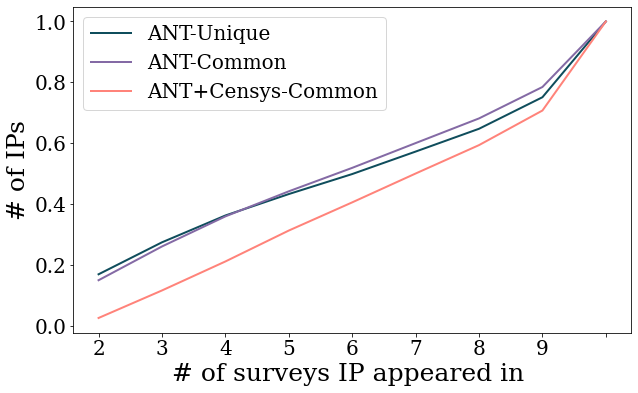

In [42]:
fig, ax=plt.subplots(figsize=(10,6))
ax = merged_df['ant_unique_cumfrac'].plot(ax=ax, color=COLORS[0], lw=2)
ax = merged_df['ant_common_cumfrac'].plot(ax=ax, color=COLORS[1], lw=2)
ax = merged_df['antcensys_common_cumfrac'].plot(ax=ax, color=COLORS[2], lw=2)

ax.set_xticklabels([str(i) for i in range(1, 10)])
ax.legend(['ANT-Unique', 'ANT-Common', 'ANT+Censys-Common'], fontsize=20)
ax.set_xlabel('# of surveys IP appeared in ', fontsize=25)
ax.set_ylabel('# of IPs', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
#plt.savefig('figs_analysis_2/host_availability.png', bbox_inches='tight')

## Sparsity

## Load combined data

In [99]:
cols = ['survey_' + str(surveynum) for surveynum in range(83, 92)]

In [218]:
merged_survey_ddfs = []
for survey in range(83, 92):
    print(survey)
    surveystr = str(survey)   
    merged_ddfs = [] 
    for p in range(10):

        files = get_files('/data1/manasvini/ant_censys_merged_new/ant_censys_merged_'+str(p) + '/' + 'survey_' + surveystr, 'parquet')
        merged_ddf = dd.read_parquet(files, blocksize='50MB').repartition(partition_size='25MB')
        merged_ddfs.append(merged_ddf)

    merged_ddf = dd.concat(merged_ddfs)

    print(merged_ddf.columns)
    print(merged_ddf.count().compute())

    if len(merged_survey_ddfs) == 0:
        merged_survey_ddfs.append(merged_ddf)
    else:
        merged_survey_ddfs.append(merged_ddf['survey_'+surveystr].to_frame())

    #break
ant_censys_merged_ddf = dd.concat(merged_survey_ddfs, axis=1, ignore_unknown_divisions=True)

for c in ['survey_' + str(i) for i in range(83, 92)]:
    ant_censys_merged_ddf[c] = ant_censys_merged_ddf[c].apply(lambda x: set_max_val(x), meta=(c, 'int64'))


83
Index(['ipint', 'survey_83'], dtype='object')
ipint        820140651
survey_83    820140651
dtype: int64
84
Index(['ipint', 'survey_84'], dtype='object')
ipint        820140651
survey_84    820140651
dtype: int64
85
Index(['ipint', 'survey_85'], dtype='object')
ipint        820140651
survey_85    820140651
dtype: int64
86
Index(['ipint', 'survey_86'], dtype='object')
ipint        820140651
survey_86    820140651
dtype: int64
87
Index(['ipint', 'survey_87'], dtype='object')
ipint        820140651
survey_87    820140651
dtype: int64
88
Index(['ipint', 'survey_88'], dtype='object')
ipint        820140651
survey_88    820140651
dtype: int64
89
Index(['ipint', 'survey_89'], dtype='object')
ipint        820140651
survey_89    820140651
dtype: int64
90
Index(['ipint', 'survey_90'], dtype='object')
ipint        820140651
survey_90    820140651
dtype: int64
91
Index(['ipint', 'survey_91'], dtype='object')
ipint        820140651
survey_91    820140651
dtype: int64


In [219]:
ant_censys_merged_ddf.columns

Index(['ipint', 'survey_83', 'survey_84', 'survey_85', 'survey_86',
       'survey_87', 'survey_88', 'survey_89', 'survey_90', 'survey_91'],
      dtype='object')

In [223]:
ant_censys_merged_ddf['/24_int'] = ant_censys_merged_ddf.map_partitions(get_24_from_int)

blks_ip_ct_df = ant_censys_merged_ddf.groupby('/24_int')[['survey_'+str(i) for i in range(83, 92)]].sum()



In [82]:
blks_ip_ct_df = blks_ip_ct_df.reset_index().compute()

Index(['/24_int', 'survey_83', 'survey_84', 'survey_85', 'survey_86',
       'survey_87', 'survey_88', 'survey_89', 'survey_90', 'survey_91'],
      dtype='object')

## Load ANT

In [13]:
dirname = '/data1/manasvini/internet_address_history_it101w-20221101/last10withipint/everalive'

files = list(set(get_files_no_pfx(dirname)))

ant_only_df = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='200MB')


In [224]:
ant_only_df.columns

Index(['ip', 'score', '/24', 'survey_81', 'survey_82', 'survey_83',
       'survey_84', 'survey_85', 'survey_86', 'survey_87', 'survey_88',
       'survey_89', 'survey_90', 'survey_91', 'ipint', '/24_int'],
      dtype='object')

In [80]:
ant_only_df['/24_int'] =  ant_only_df.map_partitions(get_24_from_int)

In [81]:

blks_ip_ct_ant_df = ant_only_df.groupby('/24')[['survey_'+str(i) for i in range(83, 92)]].sum()

blks_ip_ct_ant_df = blks_ip_ct_ant_df.reset_index().compute()



In [227]:
blks_ip_ct_ant_df['/24_int'] = blks_ip_ct_ant_df['/24'].apply(lambda x: ip2int(x))
#blks_ip_ct_df['/24_int'] = blks_ip_ct_df['/24'].apply(lambda x: ip2int(x))

#### ANT sparse blocks

In [72]:
blks_ip_ct_ant_df[blks_ip_ct_ant_df['survey_91']<15].count()

/24          2447795
survey_83    2447795
survey_84    2447795
survey_85    2447795
survey_86    2447795
survey_87    2447795
survey_88    2447795
survey_89    2447795
survey_90    2447795
survey_91    2447795
dtype: int64

#### ANT invisble blocks

In [61]:
blks_ip_ct_df[(~blks_ip_ct_df['/24_int'].isin(blks_ip_ct_ant_df['/24_int'].tolist()))].count()

/24          340714
survey_91    340714
/24_int      340714
dtype: int64

In [76]:
blks_ip_ct_df[(~blks_ip_ct_df['/24_int'].isin(blks_ip_ct_ant_df['/24_int'].tolist()))&(blks_ip_ct_df['survey_91']>=15)].count()

/24          67776
survey_91    67776
/24_int      67776
dtype: int64

#### ANT sparse, combined nonsparse

In [63]:
ant_sparse_survey91 = blks_ip_ct_ant_df[blks_ip_ct_ant_df['survey_91']<15]['/24_int'].tolist()
blks_ip_ct_df[(blks_ip_ct_df['/24_int'].isin(ant_sparse_survey91))&(blks_ip_ct_df['survey_91']>15)].count()

/24          573065
survey_91    573065
/24_int      573065
dtype: int64

In [78]:
len(ant_sparse_survey91) / len(blks_ip_ct_ant_df)

0.41643494011630194

## Load ANT/Censys(best)

In [654]:
dirname = '/data1/manasvini/censys/proto/merged_survey_new_91'
## Load Censys 
antcensys_best_survey91_ddfs = []
for i in range(10):
    antcensys_survey_part_ddf = dd.read_parquet(get_files_no_pfx(dirname + '/part_'+str(i)),  block_size='10MB')
    antcensys_best_survey91_ddfs.append(antcensys_survey_part_ddf)
antcensys_best_survey91_ddf = dd.concat(antcensys_best_survey91_ddfs)


In [628]:
antcensys_best_survey91_ddf = antcensys_best_survey91_ddf.rename(columns={'combined_survey_91':'survey_91'})

In [655]:
antcensys_best_survey91_ddf['/24'] = antcensys_best_survey91_ddf.map_partitions(get_24_from_int)

In [656]:
#antcensys_best_survey91_ddf['/24_int'] = antcensys_best_survey91_ddf.map_partitions(get_24_from_int)

antcensys_best_blks_ip_ct_df = antcensys_best_survey91_ddf.groupby('/24')[['combined_survey_'+str(91), 'ant_survey_91']].sum()

antcensys_best_blks_ip_ct_df = antcensys_best_blks_ip_ct_df.reset_index().compute()

In [657]:
antcensys_best_blks_ip_ct_df

,/24,combined_survey_91,ant_survey_91
0,16777216,255,255.0
1,16793600,7,7.0
2,16793856,5,4.0
3,16794112,7,4.0
4,16794368,5,5.0
...,...,...,...
6206515,3757682688,0,0.0
6206516,3757698048,1,1.0
6206517,3757712128,0,0.0
6206518,3757733888,0,0.0


## Sparse block geolocation

In [143]:
# combined_blk_recent_df = blks_ip_ct_df[['/24_int', 'survey_91']]
# combined_blk_recent_df['/24_str'] = combined_blk_recent_df['/24_int'].apply(lambda x:int2ip(x))
ant_blk_recent_df =blks_ip_ct_ant_df[['/24', 'survey_91']]
ant_blk_recent_df.rename(columns={'/24':'/24_str'}, inplace=True)
ant_blk_recent_df['/24']= ant_blk_recent_df['/24_str'].apply(lambda x:ip2int(x))


/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
ipinfo_cidr_filtered_ddf = dd.from_pandas(ipinfo_cidr_filtered_df, npartitions=200)

In [658]:
combined_blk_best_recent_df = antcensys_best_blks_ip_ct_df[['/24', 'combined_survey_91', 'ant_survey_91']]
combined_blk_best_recent_df['/24_str'] = combined_blk_best_recent_df['/24'].apply(lambda x:int2ip(x))

In [659]:
#ant_blk_recent_ddf = dd.from_pandas(ant_blk_recent_df, npartitions=200)
#combined_blk_recent_ddf = dd.from_pandas(combined_blk_recent_df, npartitions=200)
antcensys_best_blks_ip_ct_ddf = dd.from_pandas(combined_blk_best_recent_df, npartitions=200)

In [209]:
ant_censys_best_merged = antcensys_best_blks_ip_ct_df.merge(ant_blk_recent_df, on='/24')
ant_censys_best_merged[ant_censys_best_merged['survey_91_x']<ant_censys_best_merged['survey_91_y']]

,/24,survey_91_x,/24_str,survey_91_y


In [73]:
combined_blk_recent_ddf = combined_blk_recent_ddf.rename(columns={'/24_int':'/24'})

In [77]:
ant_blk_recent_ddf = ant_blk_recent_ddf.rename(columns={'/24_int':'/24'})

In [661]:
ipinfo_cidr_ddf.dtypes

cidr        object
/24          int64
cidr_pfx     int64
dtype: object

In [ ]:
ipinfo_cidr_ddf['/24'] = ipinfo_cidr_ddf['/24'].astype(int)

In [662]:
antcensys_blk_ct_ddf = ipinfo_cidr_filtered_ddf.merge(antcensys_best_blks_ip_ct_ddf, on='/24', how='inner')

In [147]:
ant_blk_ct_ddf = ipinfo_cidr_filtered_ddf.merge(ant_blk_recent_ddf[['/24', 'survey_91']], on='/24', how='inner')

In [114]:
ant_blk_recent_ddf['/24'] = ant_blk_recent_ddf['/24'].astype(int)

In [663]:
antcensys_blk_best_ct_ddf = ipinfo_cidr_filtered_ddf.merge(antcensys_best_blks_ip_ct_ddf, on='/24', how='inner')

In [664]:
#antcensys_blk_ddf = antcensys_blk_ct_ddf.merge(ipinfo_ddf, on='cidr', how='inner')
#ant_blk_ddf = ant_blk_ct_ddf.merge(ipinfo_ddf, on='cidr', how='inner')
antcensys_best_blk_ddf = antcensys_blk_best_ct_ddf.merge(ipinfo_ddf, on='cidr', how='inner')

In [665]:
antcensys_blk_best_ct_df = antcensys_best_blk_ddf.dropna().compute()

In [210]:
ant_blk_ct_df = ant_blk_ddf.dropna().compute()

In [165]:
antcensys_blk_df = antcensys_blk_ddf.compute()

In [668]:
#ant_blk_ct_df['name'] = ant_blk_ct_df['country'].apply(lambda x: get_ipinfo_countrycode(x))
antcensys_blk_best_ct_df['name'] = antcensys_blk_best_ct_df['country'].apply(lambda x: get_ipinfo_countrycode(x))
#antcensys_blk_df['name'] = antcensys_blk_df['country'].apply(lambda x: get_ipinfo_countrycode(x))


In [181]:
antcensys_country_nonsparse = antcensys_blk_df[antcensys_blk_df['survey_91']>15].groupby('name')['/24'].count().reset_index()

In [194]:
antcensys_country_nonsparse = antcensys_country_nonsparse.rename(columns={'/24':'/24_all'})

In [691]:
antcensys_blk_best_ct_df = antcensys_blk_best_ct_df.sort_values(by='cidr_pfx')
antcensys_blk_best_ct_df = antcensys_blk_best_ct_df.drop_duplicates(subset=['/24'], keep='last')

In [692]:
antcensys_best_country_nonsparse = antcensys_blk_best_ct_df[antcensys_blk_best_ct_df['combined_survey_91']>15].groupby('name')['/24'].count().reset_index()

In [693]:
antcensys_best_country_nonsparse = antcensys_best_country_nonsparse.rename(columns={'/24':'/24_all'})

In [694]:
ant_country_nonsparse = antcensys_blk_best_ct_df[antcensys_blk_best_ct_df['ant_survey_91']>15].groupby('name')['/24'].count().reset_index()

In [725]:
#ant_country_24_df = ant_cuntry_nonsparse[['survey_91', 'country_ipinfo', ]].groupby('country_ipinfo')['aeb_perc'].mean().reset_index()

#antcensys_country_24_df = antcensys_ipinfo_df[['aeb_perc', 'country_ipinfo', ]]\
    #                                        .groupby('country_ipinfo')['aeb_perc'].mean().reset_index()
#antcensys_cuntry_nonsparse.rename(columns={'country_ipinfo':'name', '/24_str':'all_survey_91'}, inplace=True)
#ant_cuntry_nonsparse.rename(columns={'country_ipinfo':'name', '/24_str':'ant_survey_91'}, inplace=True)   
make_world_plot(ant_country_nonsparse, antcensys_country_nonsparse, '/24', '/24_all', 'figs_pam/country_improvement_nonsparse_new.pdf', '')

Empty DataFrame
Columns: [name, diff_perc, /24, /24_all]
Index: []


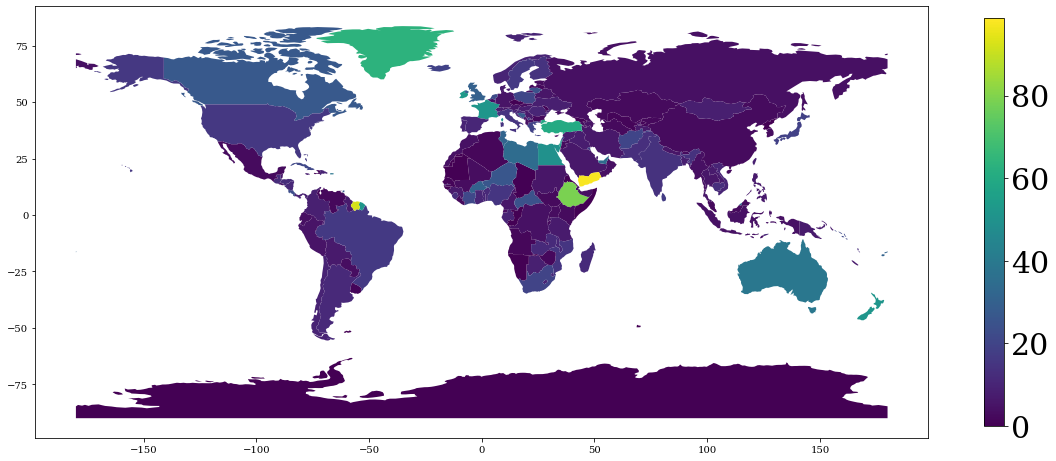

In [697]:
make_world_plot(ant_country_nonsparse, antcensys_best_country_nonsparse, '/24', '/24_all', 'figs_pam/country_improvement_best_nonsparse_new.pdf', '')

In [698]:
blk_sparse_gdf = get_comp_gdf(ant_country_nonsparse, antcensys_best_country_nonsparse, '/24', '/24_all')


In [700]:
diff_sparse_df = ant_country_nonsparse.merge(antcensys_best_country_nonsparse, on='name', how='inner')
diff_sparse_df['diff'] = diff_sparse_df['/24_all'] - diff_sparse_df['/24']

In [701]:
diff_sparse_df['diff_perc'] =  (diff_sparse_df['/24_all'] - diff_sparse_df['/24'])/diff_sparse_df['/24_all']

In [318]:
antcensys_blk_df['continent'] = antcensys_blk_df.apply(lambda x:get_continent_for_country(x['country']), axis=1)
ant_blk_df['continent'] = ant_blk_df.apply(lambda x:get_continent_for_country(x['country']), axis=1)

In [326]:
antcensys_sparse_continent_df = antcensys_blk_df[antcensys_blk_df['survey_91']<15].groupby('continent')['survey_91'].sum().reset_index()

In [325]:
ant_sparse_continent_df = ant_blk_df[ant_blk_df['survey_91']<15].groupby('continent')['survey_91'].sum().reset_index()

In [327]:
merged_sparse_df = ant_sparse_continent_df.merge(antcensys_sparse_continent_df, on='continent', how='inner')
merged_sparse_df.rename(columns={'survey_91_x':'ant_sparse', 'survey_91_y':'combined_sparse'}, inplace=True)

In [331]:
merged_sparse_df['diff'] = (merged_sparse_df['ant_sparse'] - merged_sparse_df['combined_sparse'])
merged_sparse_df['diff_perc']= 100 * merged_sparse_df['diff']/ merged_sparse_df['ant_sparse']

## Load Censys

In [462]:
   
files = get_files('/data1/manasvini/censys_address_history_new/', 'parquet')
censys_ddf = dd.read_parquet(files, blocksize='20MB').repartition(partition_size='10MB')

In [20]:
censys_24_df = censys_ddf.groupby('/24')['ipint'].count().compute()

In [66]:
censys_cols = ['censys_survey_'+ str(i) for i in range(83,92)]
blks_ip_censys_ct_df = censys_ddf.groupby('/24').sum().compute().reset_index()

censys_blk_recent_df = blks_ip_censys_ct_df[['/24', 'censys_survey_91']]
censys_blk_recent_df['/24_str'] = censys_blk_recent_df['/24'].apply(lambda x:int2ip(x))

/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## LOad ANT/Censys(best)

In [147]:
dirname_fmt = '/data1/manasvini/censys/proto/merged_survey_new_'
censys_dirname_fmt = '/data1/manasvini/censys/proto/best_survey_new_'
## Load Censys 
antcensys_best_ddfs = []
ant_best_ddfs = []
censys_best_ddfs = []
for s in range(83,92):
    snum = str(s)
    print(s)
    antcensys_best_survey_ddfs = []
    censys_best_survey_ddfs = []
    dirname = dirname_fmt + snum
    censys_dirname = censys_dirname_fmt + snum
    for i in range(10):
        antcensys_survey_part_ddf = dd.read_parquet(get_files_no_pfx(dirname + '/part_'+str(i)),  block_size='10MB')
        antcensys_best_survey_ddfs.append(antcensys_survey_part_ddf)
        censys_best_part_ddf = dd.read_parquet(get_files_no_pfx(censys_dirname + '/part_'+str(i)),  block_size='10MB')
        censys_best_survey_ddfs.append(censys_best_part_ddf)
    antcensys_survey_best_ddf = dd.concat(antcensys_best_survey_ddfs)
    censys_survey_best_ddf = dd.concat(censys_best_survey_ddfs)
    print(antcensys_survey_best_ddf.columns, censys_survey_best_ddf.columns)
    
    if len(antcensys_best_ddfs) == 0:
        antcensys_best_ddfs.append(antcensys_survey_best_ddf[['ipint', 'combined_survey_'+snum]])
        ant_best_ddfs.append(antcensys_survey_best_ddf[['ipint', 'ant_survey_'+snum]])
        censys_best_ddfs.append(censys_survey_best_ddf)
    else:
        antcensys_best_ddfs.append(antcensys_survey_best_ddf['combined_survey_'+snum].to_frame())
        ant_best_ddfs.append(antcensys_survey_best_ddf['ant_survey_'+snum].to_frame())
        censys_best_ddfs.append(censys_survey_best_ddf['survey_'+snum].to_frame())
    #break
antcensys_best_ddf = dd.concat(antcensys_best_ddfs, axis=1, ignore_unknown_divisions=True)
ant_best_ddf = dd.concat(ant_best_ddfs, axis=1, ignore_unknown_divisions=True)
censys_best_ddf = dd.concat(censys_best_ddfs, axis=1, ignore_unknown_divisions=True)

83
Index(['ipint', 'ant_survey_83', 'combined_survey_83'], dtype='object') Index(['ipint', 'survey_83'], dtype='object')
84
Index(['ipint', 'ant_survey_84', 'combined_survey_84'], dtype='object') Index(['ipint', 'survey_84'], dtype='object')
85
Index(['ipint', 'ant_survey_85', 'combined_survey_85'], dtype='object') Index(['ipint', 'survey_85'], dtype='object')
86
Index(['ipint', 'ant_survey_86', 'combined_survey_86'], dtype='object') Index(['ipint', 'survey_86'], dtype='object')
87
Index(['ipint', 'ant_survey_87', 'combined_survey_87'], dtype='object') Index(['ipint', 'survey_87'], dtype='object')
88
Index(['ipint', 'ant_survey_88', 'combined_survey_88'], dtype='object') Index(['ipint', 'survey_88'], dtype='object')
89
Index(['ipint', 'ant_survey_89', 'combined_survey_89'], dtype='object') Index(['ipint', 'survey_89'], dtype='object')
90
Index(['ipint', 'ant_survey_90', 'combined_survey_90'], dtype='object') Index(['ipint', 'survey_90'], dtype='object')
91
Index(['ipint', 'ant_survey_9

In [149]:
ant_best_ddf['/24'] = ant_best_ddf.

Index(['ipint', 'ant_survey_83', 'ant_survey_84', 'ant_survey_85',
       'ant_survey_86', 'ant_survey_87', 'ant_survey_88', 'ant_survey_89',
       'ant_survey_90', 'ant_survey_91'],
      dtype='object')

In [153]:
ant_best_ddf['/24'] = ant_best_ddf.map_partitions(get_24_from_int, meta=('ipint', int))
ant_blks_df = ant_best_ddf.groupby('/24').sum().compute()

In [155]:
antcensys_best_ddf['/24'] = antcensys_best_ddf.map_partitions(get_24_from_int, meta=('ipint', int))
antcensys_blks_df = antcensys_best_ddf.groupby('/24').sum().compute()

In [157]:
censys_best_ddf['/24'] = censys_best_ddf.map_partitions(get_24_from_int, meta=('ipint', int))
censys_blks_df = censys_best_ddf.groupby('/24').sum().compute()

In [159]:
antcensys_blks_df = antcensys_blks_df.reset_index()
ant_blks_df = ant_blks_df.reset_index()
censys_blks_df = censys_blks_df.reset_index()

## Sparsity Analysis  
- For the blocks found in ANT, how many have < 15 hosts  
- For the same set of bloclks, find how many have < 15 hosts in the combined dataset. This forms our upper bound on sparsity reduction.  
- Find the sparse ANT blocks in Censys only data. Subtract the non sparse Censys blocks from the ANT sparse blocks. This forms our lower bound on sparsity reduction.  


In [90]:
sparse_data = []
ant_all = blks_ip_ct_ant_df['/24_int'].tolist()
for s in range(83, 92):
    snum = 'survey_' + str(s)
    ant_sparse_list = blks_ip_ct_ant_df[blks_ip_ct_ant_df[snum]<15]['/24_int'].tolist()
    all_sparse = blks_ip_ct_df[blks_ip_ct_df[snum]< 15]['/24_int'].tolist()
    #print('ant sparse:', len(ant_sparse_list), 'all sparse', len(all_sparse))
    censys_avail_ant_sparse = blks_ip_censys_ct_df[blks_ip_censys_ct_df['/24'].isin(ant_sparse_list)]
   
    censys_non_sparse = censys_avail_ant_sparse[censys_avail_ant_sparse['censys_'+ snum]>=15]['/24'].count()
    #print('non sparse from ant sparse', censys_non_sparse)
    upper_bound = blks_ip_ct_df[(blks_ip_ct_df['/24_int'].isin(ant_all))&(blks_ip_ct_df[snum]<15)]['/24_int'].count()
    lower_bound = blks_ip_ct_ant_df[blks_ip_ct_ant_df[snum]<15][snum].count() - censys_non_sparse
    #print(upper_bound, lower_bound)
    sparse_data.append({'survey': s - 82, 'ant_sparse':len(ant_sparse_list), 'all_sparse': upper_bound, 'ant_sparse_censys_non_sparse': lower_bound})

In [255]:
sparse_data = []
ant_all = ant_blks_df['/24'].tolist()
for s in range(83, 92):
    snum = 'survey_' + str(s)
    ant_sparse_list = ant_blks_df[ant_blks_df['ant_'+ snum]<15]['/24'].tolist()
    all_sparse = antcensys_blks_df[antcensys_blks_df['combined_' + snum]< 15]['/24'].tolist()
    print('ant sparse:', len(ant_sparse_list), 'all sparse', len(all_sparse))
    censys_avail_ant_sparse = censys_blks_df[censys_blks_df['/24'].isin(ant_sparse_list)]
   
    censys_non_sparse = censys_blks_df[censys_blks_df[snum]>=15]['/24'].count()
    print('non sparse from ant sparse', censys_non_sparse)
    upper_bound = antcensys_blks_df[(antcensys_blks_df['/24'].isin(ant_all))&(antcensys_blks_df['combined_' + snum]<15)]['/24'].count()
    lower_bound = ant_blks_df[ant_blks_df['ant_' + snum]<15]['ant_' + snum].count() - censys_non_sparse
    print(upper_bound, lower_bound)
    sparse_data.append({'survey': s - 82, 'ant_sparse':len(ant_sparse_list), 'all_sparse': upper_bound, 'ant_sparse_censys_non_sparse': lower_bound})

ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307
ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307
ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307
ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307
ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307
ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307
ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307
ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307
ant sparse: 1084013 all sparse 1084013
non sparse from ant sparse 4099320
1084013 -3015307


In [385]:
sparse_blk_cts_df = pd.DataFrame(sparse_data)

In [389]:
sparse_blk_cts_df

,survey,ant_sparse,all_sparse,ant_sparse_censys_non_sparse,ant_sparse_m,all_sparse_m,ant_sparse_censys_non_sparse_m
0,1,2811801,2205313,2317791,2.811801,2.205313,2.317791
1,2,2794970,2207036,2312116,2.794970,2.207036,2.312116
2,3,2799557,2226367,2326657,2.799557,2.226367,2.326657
3,4,2767034,2175042,2278976,2.767034,2.175042,2.278976
4,5,2787082,2208793,2307025,2.787082,2.208793,2.307025
5,6,2772791,2184714,2284728,2.772791,2.184714,2.284728
6,7,2785564,2195021,2295059,2.785564,2.195021,2.295059
7,8,2786939,2195817,2295020,2.786939,2.195817,2.295020
8,9,2776337,2185756,2284381,2.776337,2.185756,2.284381


In [388]:
sparse_blk_cts_df['ant_sparse_m'] = sparse_blk_cts_df['ant_sparse'] / 1e6
sparse_blk_cts_df['all_sparse_m'] = sparse_blk_cts_df['all_sparse'] / 1e6
sparse_blk_cts_df['ant_sparse_censys_non_sparse_m'] = sparse_blk_cts_df['ant_sparse_censys_non_sparse'] / 1e6

In [94]:
2.45 - 1.96

0.4900000000000002

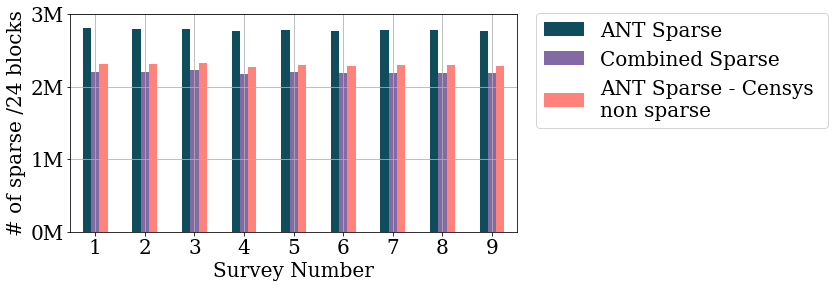

In [397]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sparse_blk_cts_df[['survey', 'ant_sparse_m','all_sparse_m', 'ant_sparse_censys_non_sparse_m']].set_index('survey').plot.bar(ax=ax, color=COLORS, grid=True)
ax.set_xlabel('Survey Number', fontsize=20)
ax.set_ylabel('# of sparse /24 blocks', fontsize=20)
ax.legend(['ANT Sparse', 'Combined Sparse', 'ANT Sparse - Censys \nnon sparse'], bbox_to_anchor=(1.02, 1.05), fontsize=20)
plt.yticks([0, 1, 2, 3], ['0M', '1M', '2M', '3M'], rotation=20) 
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
plt.savefig('figs_pam/sparsity_improvement_best_new.pdf', bbox_inches='tight')



In [98]:
sparse_blk_cts_df['lb_perc'] =  (sparse_blk_cts_df['ant_sparse'] -sparse_blk_cts_df['all_sparse'])/sparse_blk_cts_df['ant_sparse']
sparse_blk_cts_df['ub_perc'] =  (sparse_blk_cts_df['ant_sparse'] - sparse_blk_cts_df['ant_sparse_censys_non_sparse'])/sparse_blk_cts_df['ant_sparse']


In [99]:
sparse_blk_cts_df['lb_perc'] - sparse_blk_cts_df['ub_perc']

0    0.047706
1    0.046456
2    0.043232
3    0.046594
4    0.042673
5    0.044465
6    0.044198
7    0.043508
8    0.044047
dtype: float64

In [104]:
(sparse_blk_cts_df['ant_sparse'] -sparse_blk_cts_df['ant_sparse_censys_non_sparse'].mean()).mean()

488882.55555555545

## Spare blocks at the AS level

In [1601]:
antcensys_blk_df['/24_str'] = antcensys_blk_df['/24_str'].astype(str)
ant_blk_df['/24_str'] = ant_blk_df['/24_str'].astype(str)




In [1602]:
censys_blk_recent_df = censys_blk_recent_df.merge(all_asns_df[['/24_str', 'asn']], on='/24_str', how='inner')

combined_blk_recent_df = combined_blk_recent_df.merge(all_asns_df[['/24_str', 'asn']], on='/24_str', how='inner')

ant_blk_recent_df = ant_blk_recent_df.merge(all_asns_df[['/24_str', 'asn']], on='/24_str', how='inner')

In [1606]:
ant_blk_recent_df.rename(columns={'asn_x':'asn'}, inplace=True)

In [1292]:
# antcensys_blk_as_df = antcensys_blk_df.merge(all_asns_df[['/24_str', 'asn']], on='/24_str', how='inner')
# ant_blk_as_df = ant_blk_df.merge(all_asns_df[['/24_str', 'asn']], on='/24_str', how='inner')

# censys_blk_df = censys_blk_recent_df.merge(all_asns_df[['/24_str', 'asn']], on='/24_str', how='inner')

In [1603]:
censys_sparse_as_df = censys_blk_recent_df[(censys_blk_recent_df['censys_survey_91']>=15)&(~censys_blk_recent_df['/24_str'].isin(ant_blk_recent_df['/24_str'].tolist()))].groupby('asn')['/24_str'].count().reset_index()
censys_total_as_df = censys_blk_recent_df[~censys_blk_recent_df['/24_str'].isin(ant_blk_recent_df['/24_str'].tolist())].groupby('asn')['/24_str'].count().reset_index()
censys_sparse_as_df.rename(columns={'/24_str':'sparse_/24_str'}, inplace=True)
censys_sparse_as_df = censys_sparse_as_df.merge(censys_total_as_df, on='asn', how='inner')



In [1592]:
def plot_cdf(merged_sparse_as_df, figname):
    fig, ax = plt.subplots(figsize=(6,6))
    ant_sparse_ct_df = merged_sparse_as_df.groupby('ant_sparse_perc')[['asn']].count().reset_index()
    ant_sparse_ct_df['cumsum'] = ant_sparse_ct_df['asn'].cumsum()
    ant_sparse_ct_df['cumfrac'] = ant_sparse_ct_df['cumsum']/ ant_sparse_ct_df['cumsum'].max()

    antcensys_sparse_ct_df = merged_sparse_as_df.groupby('combined_sparse_perc')[['asn']].count().reset_index()
    antcensys_sparse_ct_df['cumsum'] = antcensys_sparse_ct_df['asn'].cumsum()
    antcensys_sparse_ct_df['cumfrac'] = antcensys_sparse_ct_df['cumsum']/ antcensys_sparse_ct_df['cumsum'].max()

    print(antcensys_sparse_ct_df[antcensys_sparse_ct_df['combined_sparse_perc']==50], antcensys_sparse_ct_df.max())
    print(ant_sparse_ct_df[ant_sparse_ct_df['ant_sparse_perc']==50], ant_sparse_ct_df.max())
    ax = ant_sparse_ct_df.plot(x='ant_sparse_perc', y='cumfrac', ax =ax, lw=2, c=COLORS[0], grid=True)
    antcensys_sparse_ct_df.plot(x='combined_sparse_perc', y='cumfrac', ax=ax, lw=2, c=COLORS[1], grid=True)

    ax.legend(['ANT', 'ANT+Censys'], fontsize=20, loc='lower right')

    ax.set_ylabel('Fraction of ASes', fontsize=25)
    ax.set_xlabel('% of non-sparse blocks', fontsize=25)
    #ax.set_xscale('log')
    #ax.set_ylim([10, 1e5])
    #ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
    plt.savefig(figname, bbox_inches='tight')

In [514]:
def process_sparse_cdf(ant_sparse_as_df, antcensys_sparse_as_df):
    ant_sparse_as_df.rename(columns={'/24_str':'ant_/24_str', 'sparse_/24_str':'ant_sparse_/24_str'}, inplace=True)
    antcensys_sparse_as_df.rename(columns={'/24_str':'combined_/24_str', 'sparse_/24_str':'combined_sparse_/24_str'}, inplace=True)

    ant_sparse_as_df['asn'] = ant_sparse_as_df['asn'].astype(str)
    antcensys_sparse_as_df['asn'] = antcensys_sparse_as_df['asn'].astype(str)
    ant_sparse_as_df = ant_sparse_as_df[ant_sparse_as_df['asn']!='']
    ant_sparse_as_df = ant_sparse_as_df[ant_sparse_as_df['asn']!='']
    antcensys_sparse_as_df = antcensys_sparse_as_df[antcensys_sparse_as_df['asn']!='']
    merged_sparse_as_df = antcensys_sparse_as_df.merge(ant_sparse_as_df, on='asn', how='inner')
    merged_sparse_as_df['ant_sparse_perc'] = (100 * merged_sparse_as_df['ant_sparse_/24_str']/ merged_sparse_as_df['ant_/24_str']).astype(int)
    merged_sparse_as_df['combined_sparse_perc'] = (100 * merged_sparse_as_df['combined_sparse_/24_str']/ merged_sparse_as_df['combined_/24_str']).astype(int)

    return merged_sparse_as_df

## Blocks found in ANT

In [1607]:
ant_sparse_as_df = ant_blk_recent_df[ant_blk_recent_df['survey_91']>=15].groupby('asn')['/24_str'].count().reset_index()
ant_total_as_df = ant_blk_recent_df.groupby('asn')['/24_str'].count().reset_index()
ant_sparse_as_df.rename(columns={'/24_str':'sparse_/24_str'}, inplace=True)
ant_sparse_as_df = ant_sparse_as_df.merge(ant_total_as_df, on='asn', how='inner')
# block needs to be nonsparse in Censys
antcensys_sparse_merged_as_df = censys_blk_recent_df.merge(ant_blk_recent_df, on=['/24_str', 'asn'], how='right')
antcensys_sparse_merged_filtered_as_df = antcensys_sparse_merged_as_df[(antcensys_sparse_merged_as_df['censys_survey_91']>=15)|\
                                                             (antcensys_sparse_merged_as_df['survey_91']>=15)]
antcensys_sparse_merged_filtered_as_df = antcensys_sparse_merged_filtered_as_df[antcensys_sparse_merged_filtered_as_df['/24_str'].isin(ant_blk_recent_df['/24_str'].tolist())]
antcensys_sparse_as_df = antcensys_sparse_merged_filtered_as_df.groupby('asn')['/24_str'].count().reset_index()
antcensys_total_as_df = antcensys_sparse_merged_as_df.groupby('asn')['/24_str'].count().reset_index()
antcensys_sparse_as_df.rename(columns={'/24_str':'sparse_/24_str'}, inplace=True)
antcensys_sparse_as_df = antcensys_sparse_as_df.merge(antcensys_total_as_df, on='asn', how='inner')



In [1608]:
merged_sparse_as_df = process_sparse_cdf(ant_sparse_as_df, antcensys_sparse_as_df)

In [1267]:
diff =  (merged_sparse_as_df['combined_sparse_perc'] - merged_sparse_as_df['ant_sparse_perc'])

    combined_sparse_perc   asn  cumsum   cumfrac
50                    50  5771   14841  0.319746 combined_sparse_perc      100.0
asn                     15382.0
cumsum                  46415.0
cumfrac                     1.0
dtype: float64
    ant_sparse_perc   asn  cumsum   cumfrac
50               50  6267   17492  0.376861 ant_sparse_perc      100.0
asn                14143.0
cumsum             46415.0
cumfrac                1.0
dtype: float64


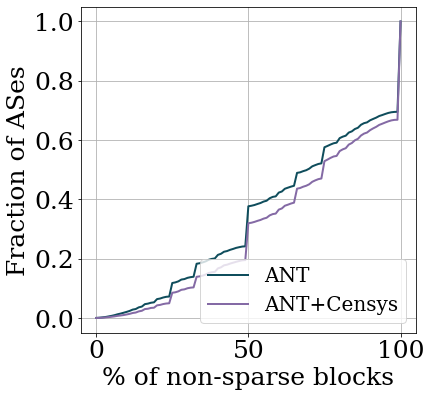

In [1609]:
plot_cdf(merged_sparse_as_df, 'figs_analysis_2/ant_as_sparse_new.pdf')

## Blcoks found only in Censys

In [1610]:
censys_sparse_as_df['asn'] = censys_sparse_as_df['asn'].astype(str)
censys_sparse_as_df = censys_sparse_as_df[censys_sparse_as_df['asn']!='']

In [1611]:
censys_sparse_as_df['censys_sparse_perc'] = (100 * censys_sparse_as_df['sparse_/24_str'] / censys_sparse_as_df['/24_str']).astype(int)

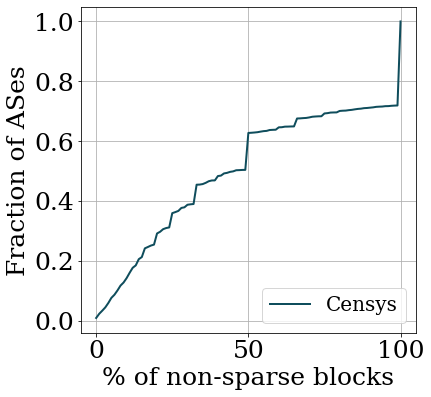

In [1612]:
fig, ax = plt.subplots(figsize=(6,6))
censys_sparse_ct_df = censys_sparse_as_df.groupby('censys_sparse_perc')[['asn']].count().reset_index()
censys_sparse_ct_df['cumsum'] = censys_sparse_ct_df['asn'].cumsum()
censys_sparse_ct_df['cumfrac'] = censys_sparse_ct_df['cumsum'] /censys_sparse_ct_df['cumsum'].max()


ax = censys_sparse_ct_df.plot(x='censys_sparse_perc', y='cumfrac', ax =ax, lw=2, c=COLORS[0], grid=True)

ax.legend(['Censys'], fontsize=20, loc='lower right')

ax.set_ylabel('Fraction of ASes', fontsize=25)
ax.set_xlabel('% of non-sparse blocks', fontsize=25)
#ax.set_ylim([10, 1e5])
#ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
plt.savefig('figs_analysis_2/censys_blocks_non_sparse_new.pdf', bbox_inches='tight')

In [1615]:
censys_sparse_as_df['censys_sparse_perc'].mean()

50.52852977925864

In [479]:
ant_sparse_as_df = ant_blk_as_df[ant_blk_as_df['survey_91']>=15].groupby('asn')['/24_str'].count().reset_index()
ant_total_as_df = ant_blk_as_df.groupby('asn')['/24_str'].count().reset_index()
ant_sparse_as_df.rename(columns={'/24_str':'sparse_/24_str'}, inplace=True)
ant_sparse_as_df = ant_sparse_as_df.merge(ant_total_as_df, on='asn', how='inner')
# block needs to be nonsparse in Censys
antcensys_sparse_merged_as_df = censys_blk_df.merge(ant_blk_as_df, on=['/24_str', 'asn'], how='outer')
antcensys_sparse_merged_filtered_as_df = antcensys_sparse_merged_as_df[(antcensys_sparse_merged_as_df['censys_survey_91']>=15)|\
                                                             (antcensys_sparse_merged_as_df['survey_91']>=15)]
antcensys_sparse_merged_filtered_as_df = antcensys_sparse_merged_filtered_as_df[antcensys_sparse_merged_filtered_as_df['/24_str'].isin(ant_blk_as_df['/24_str'].tolist())]
antcensys_sparse_as_df = antcensys_sparse_merged_filtered_as_df.groupby('asn')['/24_str'].count().reset_index()
antcensys_total_as_df = antcensys_sparse_merged_as_df.groupby('asn')['/24_str'].count().reset_index()
antcensys_sparse_as_df.rename(columns={'/24_str':'sparse_/24_str'}, inplace=True)
antcensys_sparse_as_df = antcensys_sparse_as_df.merge(antcensys_total_as_df, on='asn', how='inner')



,asn,sparse_/24_str,/24_str,censys_sparse_perc
1,1,2,4,50
2,10006,3,15,20
3,10010,72,825,8
4,10013,2,60,3
5,10015,7,10,70
...,...,...,...,...
4728,9982,6,35,17
4729,9991,133,133,100
4730,9993,6,21,28
4731,9997,1,4,25


In [35]:
dirname = '/data1/manasvini/ant_merged/aeb'

files = list(set(get_files_no_pfx(dirname)))

ant_aeb_ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='200MB')


## How blocks change 

In [726]:
ant_aeb24_df[ant_aeb24_df['aeb_perc']>= 30]

In [990]:
aeb_df = antcensys_aeb24_df[['/24_str', 'aeb']].merge(ant_aeb24_df[['/24_str', 'aeb']], on='/24_str', how='outer')

In [992]:
aeb_df.rename(columns={'aeb_x':'antcensys_aeb', 'aeb_y':'ant_aeb'}, inplace=True)

In [556]:
antcensys_blks_count_df = antcensys_blk_df[antcensys_blk_df['survey_91']>0][['/24_str', 'survey_91']]
ant_blk_count_df = ant_blk_df[ant_blk_df['survey_91']>0][['/24_str', 'survey_91']]


In [1118]:
blk_count_df = antcensys_blks_count_df.merge(ant_blk_count_df, how='outer', on='/24_str')

In [1119]:
blk_count_df.rename(columns={'survey_91_x':'antcensys_hosts', 'survey_91_y':'ant_hosts'}, inplace=True)

In [1130]:
blk_count_df = blk_count_df.fillna(0)

In [1131]:
sparse_data_pts = []
both_sparse = blk_count_df[(blk_count_df['/24_str'].isin(ant_24s_df['/24_str']))&(blk_count_df['antcensys_hosts']<15)&(blk_count_df['ant_hosts']<15)]['/24_str'].count()
sparse_data_pts.append({ 'category1':'ANT:sparse', 'category2':'Combined:sparse', 'count':both_sparse})

In [1132]:
ant_sparse_combined_nonsparse = blk_count_df[(blk_count_df['/24_str'].isin(ant_24s_df['/24_str']))&(blk_count_df['antcensys_hosts']>=15)&(blk_count_df['ant_hosts']<15)]['/24_str'].count()
sparse_data_pts.append({'category1':'ANT:sparse', 'category2':'Combined:nonsparse', 'count':ant_sparse_combined_nonsparse})

In [1133]:
# ant_nonsparse_combined_sparse = blk_stats_df[(blk_stats_df['antcensys_hosts']<15)&(blk_stats_df['ant_hosts']>=15)]['/24_str'].count()
# sparse_data_pts.append({ 'category1':'ANT:nonsparse', 'category2':'Combined:sparse', 'count':ant_nonsparse_combined_sparse})

In [1134]:
ant_nonsparse_combined_nonsparse = blk_count_df[(blk_count_df['/24_str'].isin(ant_24s_df['/24_str']))&(blk_count_df['antcensys_hosts']>=15)&(blk_count_df['ant_hosts']>=15)]['/24_str'].count()
sparse_data_pts.append({'category1':'ANT:nonsparse', 'category2':'Combined:nonsparse', 'count':ant_nonsparse_combined_nonsparse})

In [1137]:
ant_na_combined_sparse = blk_count_df[(~blk_count_df['/24_str'].isin(ant_24s_df['/24_str']))&(blk_count_df['antcensys_hosts']<15)]['/24_str'].count()
sparse_data_pts.append({ 'category1':'ANT:absent', 'category2':'Combined:sparse', 'count':ant_na_combined_sparse})

ant_na_combined_nonsparse = blk_count_df[(~blk_count_df['/24_str'].isin(ant_24s_df['/24_str']))&(blk_count_df['antcensys_hosts']>=15)]['/24_str'].count()
sparse_data_pts.append({'category1':'ANT:absent', 'category2':'Combined:nonsparse', 'count':ant_na_combined_nonsparse})

In [1138]:
sparse_df = pd.DataFrame(sparse_data_pts)
sparse_df

,category1,category2,count
0,ANT:sparse,Combined:sparse,1226421
1,ANT:sparse,Combined:nonsparse,600664
2,ANT:nonsparse,Combined:nonsparse,3430142
3,ANT:absent,Combined:sparse,108346
4,ANT:absent,Combined:nonsparse,65829


In [1226]:
sparse_df.groupby('category1')['count'].sum()

category1
ANT:absent        174175
ANT:nonsparse    3430142
ANT:sparse       1827085
Name: count, dtype: int64

In [1139]:
sparse_df.groupby('category2').sum().sum()

count    5431402
dtype: int64

In [984]:
sankey1 = hv.Sankey(sparse_df)
sankey1.opts(cmap='Set1',
             label_position='inner',
             edge_color='category1', edge_line_width=0,label_text_font_size='12pt',
             node_alpha=1.0, node_width=40, fontsize={ 'ticks': '70%',},
             width=600, height=300, bgcolor="snow",
             title="/24 block sparsity in the ANT and combined datasets")

:Sankey   [category1,category2]   (count)

In [1240]:
non_sparse_ant = blk_count_df[(blk_count_df['/24_str'].isin(ant_24s_df['/24_str']))&(blk_count_df['ant_hosts']>15)]

In [1241]:
non_sparse_ant

,/24_str,antcensys_hosts,ant_hosts
12,113.126.18.0,30,18.0
13,113.126.14.0,32,16.0
16,113.126.12.0,26,16.0
17,113.126.24.0,27,16.0
22,113.126.22.0,27,19.0
...,...,...,...
5431396,90.230.169.0,25,24.0
5431397,122.169.139.0,185,184.0
5431399,217.80.18.0,112,92.0
5431400,182.229.207.0,67,67.0


In [1080]:
reliable_data_pts = []

In [1081]:
ant_reliable_combined_reliable = aeb_df[(aeb_df['antcensys_aeb']>=0.30)&(aeb_df['ant_aeb']>=0.30)&(aeb_df['/24_str'].isin(ant_24s_df['/24_str']))]['/24_str'].count()
reliable_data_pts.append({'ANT':'ANT:reliable', 'ANT+Censys':'Combined:reliable', 'count':ant_reliable_combined_reliable})

In [1074]:
# ant_reliable_combined_unreliable = aeb_df[(aeb_df['antcensys_aeb']<0.3)&(aeb_df['ant_aeb']>=0)&(aeb_df['/24_str'].isin(ant_24s_df['/24_str']))]['/24_str'].count()
# reliable_data_pts.append({'ANT':'ANT:reliable', 'ANT+Censys':'Combined:unreliable', 'count':ant_reliable_combined_unreliable})

In [1082]:
ant_unreliable_combined_unreliable = aeb_df[(aeb_df['antcensys_aeb']<0.30)&(aeb_df['ant_aeb']<0.30)&(aeb_df['/24_str'].isin(ant_24s_df['/24_str']))]['/24_str'].count()
reliable_data_pts.append({'ANT':'ANT:unreliable', 'ANT+Censys':'Combined:unreliable', 'count':ant_unreliable_combined_unreliable})

In [1083]:
ant_unreliable_combined_reliable = aeb_df[(aeb_df['antcensys_aeb']>=0.30)&(aeb_df['ant_aeb']<0.30)&(aeb_df['/24_str'].isin(ant_24s_df['/24_str']))]['/24_str'].count()
reliable_data_pts.append({'ANT':'ANT:unreliable', 'ANT+Censys':'Combined:reliable', 'count':ant_unreliable_combined_reliable})

In [1087]:
ant_unreliable_combined_reliable = aeb_df[(aeb_df['antcensys_aeb']<0.30)&(~aeb_df['/24_str'].isin(ant_24s_df['/24_str']))]['/24_str'].count()
reliable_data_pts.append({ 'ANT':'ANT:absent', 'ANT+Censys':'Combined:unreliable', 'count':ant_unreliable_combined_reliable})

In [1088]:
ant_unreliable_combined_reliable = aeb_df[(aeb_df['antcensys_aeb']>=0.30)&(~aeb_df['/24_str'].isin(ant_24s_df['/24_str']))]['/24_str'].count()
reliable_data_pts.append({'ANT':'ANT:absent', 'ANT+Censys':'Combined:reliable', 'count':ant_unreliable_combined_reliable})

In [1089]:
reliable_df = pd.DataFrame(reliable_data_pts)

In [1100]:
reliable_df.groupby('ANT+Censys')['count'].sum()/6224727

ANT+Censys
Combined:reliable      0.720805
Combined:unreliable    0.279195
Name: count, dtype: float64

In [1102]:
reliable_df.groupby('ANT')['count'].sum()

ANT
ANT:absent         346750
ANT:reliable      3516862
ANT:unreliable    2361115
Name: count, dtype: int64

In [1094]:
reliable_df.groupby('ANT')['count'].sum().sum()

6224727

In [1242]:
aeb_df[(aeb_df['/24_str'].isin(non_sparse_ant['/24_str'].tolist()))& (aeb_df['ant_aeb']>0.3)]

,/24_str,antcensys_aeb,ant_aeb
0,1.0.0.0,1.000000,1.000000
39,1.0.102.0,0.330882,0.301471
72,1.0.136.0,0.909449,0.562008
74,1.0.138.0,0.762363,0.517857
77,1.0.141.0,0.896654,0.509843
...,...,...,...
6024509,209.96.64.0,0.962500,0.962500
6059307,113.230.173.0,0.543103,0.534483
6067548,134.65.200.0,0.888889,0.888889
6081183,193.0.176.0,0.902439,0.902439


In [1017]:
sankey1 = hv.Sankey(reliable_df)
sankey1.opts(cmap='Set1',
             label_position='inner',
             edge_color='ANT', edge_line_width=0,label_text_font_size='12pt',
             node_alpha=1.0, node_width=40, fontsize={ 'ticks': '70%',},
             width=600, height=300, bgcolor="snow",
             title="/24 block availability in the ANT and combined datasets")

:Sankey   [ANT,ANT+Censys]   (count)

In [1010]:
reliable_df

,ANT,ANT+Censys,count
0,ANT:reliable,Combined:reliable,3516862
1,ANT:unreliable,Combined:unreliable,1158125
2,ANT:unreliable,Combined:reliable,826077
3,ANT:absent,Combined:unreliable,220721
4,ANT:absent,Combined:reliable,126029


In [1012]:
826077/(1158125+826077)

0.4163270675062317

In [1013]:
126029/346750

0.36345782263878873